# Notebook #2 - Simultaneous Simulation Loop for investigation of the forcing frequency for ammonia synthesis with dynamic catalysis

This Jupyter Notebook is part of the Supporting Information for the ESCAPE Conference paper "Dynamic Catalysis for Ammonia Synthesis: Cyclic Steady-State Simulation and Insights into Forcing Signal Parameters" by Carolina Colombo Tedesco, John R. Kitchin, and Carl Laird.

Feel free to open an issue on GitHub (https://github.com/ccolomb2/dynamic_catalysis_NH3) or contact the author or if you have any questions (ccolomb@andrew.cmu.edu).

22 Reactions:
    
Terrace:\
    0. N2   +  \*(T) <--> N2(T) \
    1. N2(T)  +  \*(T) <--> 2N(T) \
    2. H2   + 2(T) <--> 2H(T)\
    3. NH3(T) +  \*(T) <--> NH2(T) + H(T) (note that this is the reverse of ammonia formation)\
    4. NH2(T) +  \*(T) <--> NH(T)  + H(T)\
    5. NH(T)  +  \*(T) <--> N(T)   + H(T)\
    6. NH3  +  \*(T) <--> NH3(T)
    
    
Steps:\
    7. N2 + \*(S) <--> N2(S1)\
    8. N2(S) + \*(S) <--> 2N(S) (considered as non-happening)\
    9. H2 + 2(S) <--> 2H(S)\
    10. NH3(S) + \*(S) <--> NH2(S) + H(S)\
    11. NH2(S) + \*(S) <--> NH(S) + H(S)\
    12. NH(S) + \*(S) <--> N(S) + H(S)\
    13. NH3  +  \*(S) <--> NH3(S)
    
Diffusion:\
    14. N(T) + \*(S) <--> N(S) + \*(T)\
    15. H(T) + \*(S) <--> H(S) + \*(T) (considered as non-happening)\
    16. NH3(T) + \*(S) <--> NH3(S) + \*(T)\
    17. NH2(T) + \*(S) <--> NH2(S) + \*(T)\
    18. NH(T) + \*(S) <--> NH(S) + \*(T)\
    19. N2(S) + \*(T) <--> N(S) + N(T) (considered as non-happening)\
    20. N2(S) + \*(S3) <--> N(S) + N(S3)\
    21. N(T) + \*(S3) <--> N(S3) + \*(T)

kf are rate constant for the forward reactions depicted above
kb are rate constants for the backward reactions depicted above


16 Species:
    
Terrace:\
    0. N2(T)\
    1. N(T)\
    2. H(T)\
    3. NH3(T)\
    4. NH2(T)\
    5. NH(T)

Gas phase:\
    6. N2\
    7. H2\
    8. NH3
    
Steps:\
    9. N2(S)\
    10. N(S)\
    11. H(S)\
    12. NH3(S)\
    13. NH2(S)\
    14. NH(S)\
    15. N(S3)
    
The listed numbers are the indexes for the ODEs for each species

In [ ]:
%%capture
import os, sys, subprocess
if "google.colab" in sys.modules:
    cmd = "pip install --upgrade watermark blackcellmagic"
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)

    !pip install idaes-pse --pre
    !idaes get-extensions --to ./bin #downloads IDAES tools into bin folder
    os.environ['PATH'] += ':bin' #adds bin to system PATH

!pip install munch

TimeoutException: 

In [ ]:
from munch import Munch
import numpy as np
from pyomo.environ import (ConcreteModel, Constraint, Objective, Var, Param, Reals, NonNegativeReals,
                           SolverFactory, value, sin, cos, Set, exp, Any, ConstraintList,
                           TransformationFactory, assert_optimal_termination, RangeSet, maximize)
from pyomo.dae import ContinuousSet, DerivativeVar
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
from scipy import signal
from tqdm import tqdm
# import idaes
from scipy.optimize import minimize
import time
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as colors
import math
from IPython.display import Image, display
from tqdm import tqdm
from scipy.interpolate import interp1d
from pyomo.core.expr.visitor import identify_variables
from pyomo.core.expr import differentiate
from matplotlib.ticker import FormatStrFormatter
from scipy.interpolate import Akima1DInterpolator
import csv
import signal

In [ ]:
class Params:
    """
    Declares reaction system and CSTR model parameters
    """

    def __init__(self,  T = 593.15, # K
                        T_orig = 593.15, # K
                        T_gas = 593.15, # K
                        T_ref = 1,
                        T_c = 500, # K
                        Q_in = 1, # cm3/s
                        Q_out = 1,
                        P = 50, # atm
                        R_e = 1.987e-3, # kcal/mol K
                        R_k = 8.31451e7, # g cm2/mol K s
                        R = 82.057, # cm3 atm/K mol
                        V = 1.0, # cm3
                        SDTOT = 2.6188e-9, # moles/cm2
                        RATIO_S = 0.02,
                        abyv = 1200, # cm2 catalyst/cm3 reac volume
                        MW_H = 1.00797, # g/mol
                        MW_N = 14.0067, # g/mol
                        MWON = 0, # g/mol
                        X_H2  = 3,
                        X_N2  = 1,
                        X_NH3 = 0,
                        beta = np.array([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1]),
                        Stick = np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
                        Isobaric = 0,
                        A = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1.56E19, 1.56E19, 1.56E19, 1.56E19, 1.56E19, \
                                      0, 0, 1.56E19]).reshape(16,1),
                        StrainCoef = [-0.04, 0.0, 0.04],
                        Q_ref = 134.21,
                        Q_target = 134.21, # binding energy of Ru
                        alpha = np.array([0.62036, 1, 0.17, 0.14, 0.41, 0.71, 0.62036, 1.057, 0.18, 0.14, 0.391, 0.708, 1.057]),
                        Qi_ref = np.array([-2.0779, 134.21, 57.4245, 12.2999, 45.8833, 82.5372, 9.451, 106.224, 58.0824, 22.6759,
                        63.9298, 91.8554, 106.224]),
                        mb = [0.514, 0.581, 0.725, 0.608, 0.855,0.809, 0.553, 0.470,0.183, 0.346],
                        b = [48.6,28.0,25.5,27.5,40.6,26.5,27.7,22.3,18.0,20.1],
                        ):

        self.T = T # Temperature on the simulated CSTR
        self.T_orig = T_orig
        self.T_gas = T_gas
        self.T_c = T_c
        self.T_ref = T_ref
        self.Q_in = Q_in
        self.Q_out = Q_out
        self.P = P # Standard pressure
        self.R_e = R_e
        self.R_k = R_k
        self.R = R
        self.V = V
        self.SDTOT = SDTOT
        self.RATIO_S = RATIO_S
        self.abyv  = abyv
        self.MW_H = MW_H
        self.MW_N = MW_N
        self.MWON = MWON
        self.X_H2 = X_H2
        self.X_N2 = X_N2
        self.X_NH3 = X_NH3
        self.beta = beta
        self.Stick = Stick
        self.Isobaric = Isobaric
        self.A = A
        self.StrainCoef = StrainCoef
        self.Q_ref = Q_ref
        self.Q_target = Q_target # binding energy of Ru
        self.Qi_ref = Qi_ref
        self.mb = mb
        self.b = b
        self.alpha = alpha

In [ ]:
def initial_calculations(params):

    RATIO_S = params.RATIO_S
    SDTOT  = params.SDTOT
    MW_H = params.MW_H
    MW_N = params.MW_N
    X_H2 = params.X_H2
    X_N2 = params.X_N2
    X_NH3 = params.X_NH3
    P = params.P
    R = params.R
    T = params.T
    X_N2 = params.X_N2
    X_NH3 = params.X_NH3

    SDEN_T = (1 - RATIO_S) * SDTOT
    SDEN_S = RATIO_S * SDTOT

    MW_H2 = 2*MW_H # g/mol
    MW_N2 = 2*MW_N # g/mol
    MW_NH3 = MW_N + 3*MW_H # g/mol

    Y_H2  = X_H2 /(X_H2+X_N2+X_NH3)
    Y_N2  = X_N2 /(X_H2+X_N2+X_NH3)
    Y_NH3 = X_NH3/(X_H2+X_N2+X_NH3)
    c_tot = P/(R*T) # mol/cm3
    c_H2 = Y_H2*c_tot # mol/cm3
    c_N2 = Y_N2*c_tot # mol/cm3
    c_NH3 = Y_NH3*c_tot # mol/cm3


    return Munch(SDEN_T=SDEN_T, SDEN_S=SDEN_S, MW_H2=MW_H2, MW_N2=MW_N2, MW_NH3=MW_NH3, Y_H2=Y_H2, \
                 Y_NH3=Y_NH3, c_tot=c_tot, c_H2=c_H2, c_N2=c_N2, c_NH3=c_NH3)

In [ ]:
params = Params()

In [ ]:
# code source: chatGPT

data = {}

with open('data_ammonia.csv', mode='r') as file:
    reader = csv.reader(file)
    current_section = None  # Track the current section label
    temp_data = []          # Temporarily hold data for a section

    for row in reader:
        # Strip any whitespace and skip empty rows
        row = [val.strip() for val in row]
        if not any(row):
            continue  # Skip blank rows

        # If the row is a label, save the current section data and start a new section
        if len(row) == 1:  # A label row
            if current_section is not None and temp_data:
                # Save the previous section's data
                data[current_section] = (
                    np.array(temp_data, dtype=float)
                    if len(temp_data[0]) > 1 else np.array(temp_data, dtype=float).flatten()
                )
                temp_data = []  # Reset for the next section

            current_section = row[0]  # Update the current section label

        elif current_section:  # Data row (non-empty)
            try:
                temp_data.append([float(val) for val in row])  # Parse as float
            except ValueError:
                print(f"Warning: Could not parse row: {row}")

    # Save the last section
    if current_section is not None and temp_data:
        data[current_section] = (
            np.array(temp_data, dtype=float)
            if len(temp_data[0]) > 1 else np.array(temp_data, dtype=float).flatten()
        )

In [ ]:
Stoic = data.get("Stoic")
Strain_Coef_H = data.get("Strain_Coef_H")
Strain_Coef_S = data.get("Strain_Coef_S")
A_LSR = data.get("A_LSR")

A_N2s1_h = data.get("A_N2s1_h")
A_N2s1_l = data.get("A_N2s1_l")
A_Ns1_h = data.get("A_Ns1_h")
A_Ns1_l = data.get("A_Ns1_l")
A_Hs1_h = data.get("A_Hs1_h")
A_Hs1_l = data.get("A_Hs1_l")
A_NH3s1_h = data.get("A_NH3s1_h")
A_NH3s1_l = data.get("A_NH3s1_l")
A_NH2s1_h = data.get("A_NH2s1_h")
A_NH2s1_l = data.get("A_NH2s1_l")
A_NHs1_h = data.get("A_NHs1_h")
A_NHs1_l = data.get("A_NHs1_l")
A_N2s2_h = data.get("A_N2s2_h")
A_N2s2_l = data.get("A_N2s2_l")
A_Ns2_h = data.get("A_Ns2_h")
A_Ns3_l = data.get("A_Ns3_l")
A_Ns3_h = data.get("A_Ns3_h")
A_Ns2_l = data.get("A_Ns2_l")
A_Hs2_h = data.get("A_Hs2_h")
A_Hs2_l = data.get("A_Hs2_l")
A_NH3s2_h = data.get("A_NH3s2_h")
A_NH3s2_l = data.get("A_NH3s2_l")
A_NH2s2_h = data.get("A_NH2s2_h")
A_NH2s2_l = data.get("A_NH2s2_l")
A_NHs2_h = data.get("A_NHs2_h")
A_NHs2_l = data.get("A_NHs2_l")
A_H2_h = data.get("A_H2_h")
A_H2_l = data.get("A_H2_l")
A_N2_h = data.get("A_N2_h")
A_N2_l = data.get("A_N2_l")
A_NH3_h = data.get("A_NH3_h")
A_NH3_l = data.get("A_NH3_l")
A_v_h = data.get("A_v_h")
A_v_l = data.get("A_v_l")

In [ ]:
def amm_thermo4(params, A6_LSR,A6_Strain,A7_Strain, A6_Cov):

    """
    This function uses thermodynamic parameters depending on the temperature and calculates
    and returns Cp/R, H/RT and G/RT
    """

    T = params.T
    T_c = params.T_c
    abyv = params.abyv
    R_e = params.R_e

    ic = initial_calculations(params)

    if T > 791.5:
        A_H2 = A_H2_h
        A_N2 = A_N2_h
    else:
        A_H2 = A_H2_l
        A_N2 = A_N2_l

    if T > 592.4:
        A_NH3 = A_NH3_h
    else:
        A_NH3 = A_NH3_l

    A_h = [A_N2s1_h, A_Ns1_h, A_Hs1_h, A_NH3s1_h, A_NH2s1_h, A_NHs1_h, A_N2, A_H2, A_NH3, A_v_h,
           A_N2s2_h, A_Ns2_h, A_Hs2_h, A_NH3s2_h, A_NH2s2_h, A_NHs2_h, A_v_h, A_Ns3_h]

    A_l = [A_N2s1_l, A_Ns1_l, A_Hs1_l, A_NH3s1_l, A_NH2s1_l, A_NHs1_l, A_N2, A_H2, A_NH3, A_v_l,
           A_N2s2_l, A_Ns2_l, A_Hs2_l, A_NH3s2_l, A_NH2s2_l, A_NHs2_l, A_v_l, A_Ns3_l]

    if T > T_c:
        A_thermo = A_h
    else:
        A_thermo = A_l

            # Collapse A_thermo from shape (18, 7, 1) to (18, 7)
    A_thermo = np.squeeze(A_thermo, axis=1)  # Remove the last dimension

    A6_LSR = A6_LSR.reshape((13, 1))
    A6_Strain = A6_Strain.reshape((13, 1))

    # Calculate A6_Correction
    # A6_Correction = A6_LSR - A6_Strain
    A6_Correction = A6_LSR + A6_Cov - A6_Strain

    # Subtract A6_Correction from specific rows of column 6 in A
    A_thermo[0:6, 5] -= A6_Correction[0:6, 0]
    A_thermo[10:16, 5] -= A6_Correction[6:12, 0]
    A_thermo[17, 5] -= A6_Correction[12, 0]

    # Add A7_Strain to specific rows of column 7 in A
    A_thermo[0:6, 6] += A7_Strain[0:6, 0]
    A_thermo[10:16, 6] += A7_Strain[6:12, 0]
    A_thermo[17, 6] += A7_Strain[12, 0]

    T_Cp = [1, T, T**2, T**3, T**4]
    T_H = [1, T/2, T**2/3, T**3/4, T**4/5, 1/T]
    T_S = [np.log(T), T, T**2/2, T**3/3, T**4/4, 1]

    CpOR = np.dot(T_Cp, A_thermo[:, :5].T)
    HORT = np.dot(T_H, A_thermo[:, :6].T)

    columns = [0, 1, 2, 3, 4, 6]
    A_columns = A_thermo[:, columns]
    SOR = np.dot(T_S, A_columns.T)

    GORT = HORT - SOR

    return HORT, GORT

In [ ]:
def amm_BEP_LSR4(params, strain, A6_Cov):

    T = params.T
    Q_ref = params.Q_ref
    Q_target = params.Q_target
    alpha = params.alpha
    Qi_ref = params.Qi_ref
    R_e = params.R_e
    A = params.A
    mb = params.mb
    b = params.b
    R_e = params.R_e

    # these operations work and the results is an array with 13 elements
    Q = Qi_ref + alpha * (Q_target - Q_ref)
    A6_LSR = ((alpha * (Q_target - Q_ref)) / R_e).reshape(13,1)


    # these A depend on strain, and they are given to the thermo function as inputs
    # they serve as correction to calculate the thermo parameters Cp, H, G
    A6_Strain = (Strain_Coef_H @ np.array([strain, 1])).reshape(13,1)
    A7_Strain = (Strain_Coef_S @ np.array([strain ** 2, strain, 1])).reshape(13,1)
#     print(A)
    A_New = np.dot(A_LSR, np.array([strain ** 2, strain, 1]))
    A[0:8, 0] = A_New[0:8]
    A[13:15, 0] = A_New[8:10]
#     print(A)

    HORT, GORT = amm_thermo4(params, A6_LSR, A6_Strain, A7_Strain, A6_Cov)

    # heat of reaction calculated from
    HRXN = np.dot(HORT, np.dot(Stoic.T, T * R_e))

    Ea = np.zeros(22)

    # corrected!
    Ea[1] = mb[0] * HRXN[1] + b[0] # N2 dissociation (Terrace)

    # corrected!
    Ea[3] = mb[3] * HRXN[3] + b[3] # NH3 dehydrogenation (Terrace)

     # corrected!
    Ea[4] = mb[2] * HRXN[4] + b[2] # NH2 dehydrogenation (Terrace)

    # corrected!
    Ea[5] = mb[1] * HRXN[5] + b[1]  # NH dehydrogenation (Terrace)


    # Reactions 6, 7 and 9 are adsorptions, here considered barrierless


    Ea[8] = mb[4] * HRXN[8] + b[4] # N2 dissociation (Step), considered as non-happening

    # corrected!
    Ea[10] = mb[7] * HRXN[10] + b[7] # NH3 dehydrogenation (Step)

    # corrected!
    Ea[11] = mb[6] * HRXN[11] + b[6] # NH2 dehydrogenation (Step)

    # corrected!
    Ea[12] = mb[5] * HRXN[12] + b[5] # NH dehydrogenation (Step)

    Ea[14] = (strain * 100) * (0.46921131) + 20.20056000 # N* Diffusion
    Ea[15] = (strain * 100) * (0.10199344) + 9.27356278 # H* Diffusion
    Ea[16] = (strain * 100) * (0.06629750) + 13.18263333 # NH3* Diffusion
    Ea[17] = (strain * 100) * (0.14124250) + 5.34992000 #  NH2* Diffusion
    Ea[18] = (strain * 100) * (0.23348250) + 15.03512000 # NH* Diffusion

    # corrected!
    Ea[19] = mb[8] * HRXN[19] + b[8] # N2 dissociation (Step-Terrace)

    # corrected!
    Ea[20] = mb[9] * HRXN[20] + b[9] # N2 dissociation (U Step-L Step)
    Ea[21] = (strain * 100) * (0.46921131) + 20.20056000 # N(S3) Diffusion

    return Ea, GORT, A


In [ ]:
def amm_kinetics4(params, t, s):

    T = params.T
    R_e = params.R_e
    R_k = params.R_k
    R = params.R
    A = params.A
    Stick = params.Stick
    SDTOT = params.SDTOT
    abyv = params.abyv
    beta = params.beta
    T_ref = params.T_ref
    MWON = params.MWON
    T_gas = params.T_gas


    amplitude = params.amplitude
    offset = params.offset

    A = np.array(A, dtype=np.float64)
    T = np.array(T, dtype=np.float64)
    beta = np.array(beta, dtype=np.float64)
    abyv = np.float64(abyv)
    R_e = np.float64(R_e)


    ic = initial_calculations(params)

    strain = amplitude * np.sin(2 * np.pi * 1 * t) + offset

    T_ref = 1  # Reference Temperature [K]

    # Lateral Interactions
    Effects = np.array([[-6.00, 0.00, 0.00, 0.00, 0.00, 0.00, 0.00],
                        [0.00, -47.0179, -17.7545, -25.1631, -20.7620, -48.7823, -47.0179],
                        [0.00, -17.7545, -6.7043, -9.5019, -7.8400, -18.4208, -17.7545],
                        [0.00, -25.1631, -9.5019, -13.4668, -11.1115, -26.1074, -25.1631],
                        [0.00, -20.7620, -7.8400, -11.1115, -19.8316, -21.5412, -20.7620],
                        [0.00, -48.7823, -18.4208, -26.1074, -21.5412, -50.6129, -48.7823],
                        [0.00, -47.0179, -17.7545, -25.1631, -20.7620, -48.7823, -47.0179]])

    s = s.reshape(16,1)

    # Calculate A6_Cov, to use in the correction of NASA polynomial coefficients
    A6_Cov = np.zeros(13)

    A6_Cov = A6_Cov.reshape(13,1)

    A6_Cov[0:6] = ((Effects[0:6, 0:6] / 2) @ (s[0:6] / (ic.SDEN_T * abyv)) / R_e)

    A6_Cov[6:13] = ((Effects / 2) @ (s[9:16] / (ic.SDEN_S * abyv)) / R_e)

    A6_Cov = A6_Cov.reshape(13,1)
#     print(A6_Cov)

#     Ea, _, _, _, CpOR, HORT, GORT, _, A_thermo = amm_BEP_LSR4(T, Stoic, strain, A6_Cov)



    Ea, GORT, A = amm_BEP_LSR4(params, strain, A6_Cov)

    Stoic_gas = np.zeros((22, 18))
    Stoic_gas[0, 6] = -1
    Stoic_gas[2, 7] = -1
    Stoic_gas[7, 6] = -1
    Stoic_gas[6, 8] = -1
    Stoic_gas[9, 7] = -1
    Stoic_gas[13, 8] = -1

    kf = np.zeros(22)

    # Terrace site reactions
    # Ea[0] = 0 per initiation of the array, means there is no energy barrier for this adsorption
    kf[0] = 1 * (Stick[0] / (1 - MWON * Stick[0] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[0]) * \
            np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_N2)) * np.exp(-Ea[0] / (R_e * T_gas))  # N2   +  *(T) <--> N2(T)

    # here matlab uses Ea(2), which is calculated
    kf[1] = 1 * A[0] * ((T / T_ref) ** beta[1]) / abyv * np.exp(-Ea[1] / (R_e * T))  # N2(T)  +  *(T) <--> 2N(T)

    # stick[1] seems correct.
    # this ea should be zero, and it is.
    kf[2] = 1 * (Stick[1] / (1 - MWON * Stick[1] / 2)) / (abyv * SDTOT ** 2) * \
            ((T_gas / T_ref) ** beta[2]) * np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_H2)) * \
            np.exp(-Ea[2] / (R_e * T_gas))  # H2   + 2(T) <--> 2H(T)

    # ok, ea formula corrected
    kf[3] = 1 * A[1] * ((T / T_ref) ** beta[3]) / abyv * np.exp(-Ea[3] / (R_e * T))  # NH3(T) +  *(T) <--> NH2(T) + H(T)

    # ok, ea formula corrected
    kf[4] = 1 * A[2] * ((T / T_ref) ** beta[4]) / abyv * np.exp(-Ea[4] / (R_e * T))  # NH2(T) +  *(T) <--> NH(T)  + H(T)

    # ok, ea formula corrected
    kf[5] = 1 * A[3] * ((T / T_ref) ** beta[5]) / abyv * np.exp(-Ea[5] / (R_e * T))  # NH(T)  +  *(T) <--> N(T)   + H(T)

    # this ea should be zero, and it is.
    kf[6] = 1 * (Stick[2] / (1 - MWON * Stick[2] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[6]) * \
            np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_NH3)) * np.exp(-Ea[6] / (R_e * T_gas))  # NH3  +  *(T) <--> NH3(T)

    # Step site reactions
    kf[7] = 1 * (Stick[3] / (1 - MWON * Stick[3] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[7]) * \
            np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_N2)) * np.exp(-Ea[7] / (R_e * T_gas))  # N2 + *(S) <--> N2(S1)

    # we consider this reaction does not happen
    # it is indeed my reaction 8, so ok
    # kf[8] = 0 * A[4] * ((T / T_ref) ** beta[8]) / abyv * np.exp(-Ea[8] / (R_e * T))  # N2(S) + *(S) <--> 2N(S)

    # this ea should be zero, and it is.
    kf[9] = 1 * (Stick[4] / (1 - MWON * Stick[4] / 2)) / (abyv * SDTOT ** 2) * \
            ((T_gas / T_ref) ** beta[9]) * np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_H2)) * \
            np.exp(-Ea[9] / (R_e * T_gas))  # H2 + 2(S) <--> 2H(S)

    kf[10] = 1 * A[5] * ((T / T_ref) ** beta[10]) / abyv * np.exp(-Ea[10] / (R_e * T))  # NH3(S) + *(S) <--> NH2(S) + H(S)

    kf[11] = 1 * A[6] * ((T / T_ref) ** beta[11]) / abyv * np.exp(-Ea[11] / (R_e * T))  # NH2(S) + *(S) <--> NH(S) + H(S)

    kf[12] = 1 * A[7] * ((T / T_ref) ** beta[12]) / abyv * np.exp(-Ea[12] / (R_e * T))  # NH(S) + *(S) <--> N(S) + H(S)

    # this ea should be zero, and it is.
    kf[13] = 1 * (Stick[5] / (1 - MWON * Stick[5] / 2)) / SDTOT * ((T_gas / T_ref) ** beta[13]) * \
             np.sqrt(R_k * T_gas / (2 * np.pi * ic.MW_NH3)) * np.exp(-Ea[13] / (R_e * T_gas))  # NH3  +  *(S) <--> NH3(S)

    # Diffusion reactions
    kf[14] = 1 * A[8] * ((T / T_ref) ** beta[14]) / abyv * np.exp(-Ea[14] / (R_e * T))  # N(T) + *(S) <--> N(S) + *(T)
    # kf[15] = 0 * A[9] * ((T / T_ref) ** beta[15]) / abyv * np.exp(-Ea[15] / (R_e * T))  # H(T) + *(S) <--> H(S) + *(T)
    kf[16] = 1 * A[10] * ((T / T_ref) ** beta[16]) / abyv * np.exp(-Ea[16] / (R_e * T))  # NH3(T) + *(S) <--> NH3(S) + *(T)
    kf[17] = 1 * A[11] * ((T / T_ref) ** beta[17]) / abyv * np.exp(-Ea[17] / (R_e * T))  # NH2(T) + *(S) <--> NH2(S) + *(T)
    kf[18] = 1 * A[12] * ((T / T_ref) ** beta[18]) / abyv * np.exp(-Ea[18] / (R_e * T))  # NH(T) + *(S) <--> NH(S) + *(T)
    # kf[19] = 0 * A[13] * ((T / T_ref) ** beta[19]) / abyv * np.exp(-Ea[19] / (R_e * T))  # N2(S) + *(T) <--> N(S) + N(T)
    kf[20] = 1 * A[14] * ((T / T_ref) ** beta[20]) / abyv * np.exp(-Ea[20] / (R_e * T))  # N2(S) + *(S3) <--> N(S) + N(S3)
    kf[21] = 1 * A[15] * ((T / T_ref) ** beta[21]) / abyv * np.exp(-Ea[21] / (R_e * T))  # N(T) + *(S3) <--> N(S3) + *(T)

#     GORT = GORT.reshape(1, 18)
    GORT_e = GORT @ (Stoic).T
    Kp = np.exp(-GORT_e)
    Kc = Kp * (1 / (R * T)) ** np.sum(Stoic_gas, axis=1)
    kb = kf / Kc


    return kf, kb, strain

In [ ]:
# Read the CSV file
df = pd.read_csv('solve_ivp_ammonia_solution_100hz.csv')

# Extract time and the variables into arrays
times_ivp = df['time'].values

# Scale to [0, 1]
t_min = np.min(times_ivp)
t_max = np.max(times_ivp)
times_ivp = (times_ivp - t_min) / (t_max - t_min)

solution_N2_T = df['N2_T'].values
solution_N_T = df['N_T'].values
solution_H_T = df['H_T'].values
solution_NH3_T = df['NH3_T'].values
solution_NH2_T = df['NH2_T'].values
solution_NH_T = df['NH_T'].values

solution_N2 = df['N2'].values
solution_H2 = df['H2'].values
solution_NH3 = df['NH3'].values

solution_N2_S = df['N2_S'].values
solution_N_S = df['N_S'].values
solution_H_S = df['H_S'].values
solution_NH3_S = df['NH3_S'].values
solution_NH2_S = df['NH2_S'].values
solution_NH_S = df['NH_S'].values
solution_N_S3 = df['N_S3'].values

In [ ]:
data_dict = {
    'time': times_ivp,
    'N2_T': (solution_N2_T),
    'N_T': (solution_N_T),
    'H_T': (solution_H_T),
    'NH3_T': (solution_NH3_T),
    'NH2_T': (solution_NH2_T),
    'NH_T': (solution_NH_T),
    'N2': (solution_N2),
    'H2': (solution_H2),
    'NH3': (solution_NH3),
    'N2_S': (solution_N2_S),
    'N_S': (solution_N_S),
    'H_S': (solution_H_S),
    'NH3_S': (solution_NH3_S),
    'NH2_S': (solution_NH2_S),
    'NH_S': (solution_NH_S),
    'N_S3': (solution_N_S3),
}

In [ ]:
array_of_arrays_solutions = [solution_N2_T, solution_N_T, solution_H_T, solution_NH3_T,
                             solution_NH2_T, solution_NH_T, solution_N2, solution_H2,
                             solution_NH3, solution_N2_S, solution_N_S, solution_H_S,
                             solution_NH3_S, solution_NH2_S, solution_NH_S, solution_N_S3]

solution_python = []

for i, array in enumerate(array_of_arrays_solutions):
    solution_python.append(np.mean(array[-1000:-1]))

In [ ]:
def create_pyomo_model(params):
    """
    Creates the pyomo model for the CSTR. Uses Backwards Finite Difference method to discretize the time span and
    a system of equations from the ODE system modelled here.

    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"

    Returns:
        Discretized Pyomo model
    """

    abyv = params.abyv
    Q_in = params.Q_in
    Q_out = params.Q_out
    V = params.V

    amplitude = params.amplitude
    offset = params.offset

    freq_osci = params.freq_osci

    ic = initial_calculations(params)


    # Create Pyomo model and parameters
    m = ConcreteModel()
    m.params = params

    # # Create time span
    # m.times = ContinuousSet(bounds=(0, 30))


    # Create time span
    # Scaling time to be between 0 and 1
    m.times = ContinuousSet(bounds=(0, 1))
    # True time span, dependent of tau
    m.tau = Var(m.times)

    # m.freq_osci = Param(initialize= m.freq_osci, mutable=True)

    # # Parameter fir the final time to be equal the number of periods times the wave period
    m.tf = Param(initialize= 1 / freq_osci, mutable=True)

    noise = np.random.normal(0, 1e-6)

    interp_function_N2_T = Akima1DInterpolator(times_ivp, solution_N2_T)
    interp_function_N_T = Akima1DInterpolator(times_ivp, solution_N_T)
    interp_function_H_T = Akima1DInterpolator( times_ivp,solution_H_T)
    interp_function_NH3_T = Akima1DInterpolator(times_ivp, solution_NH3_T)
    interp_function_NH2_T = Akima1DInterpolator(times_ivp, solution_NH2_T)
    interp_function_NH_T = Akima1DInterpolator(times_ivp, solution_NH_T)
    interp_function_N2 = Akima1DInterpolator(times_ivp,solution_N2)
    interp_function_H2 = Akima1DInterpolator(times_ivp, solution_H2)
    interp_function_NH3 = Akima1DInterpolator(times_ivp, solution_NH3)
    interp_function_N2_S = Akima1DInterpolator(times_ivp, solution_N2_S)
    interp_function_N_S = Akima1DInterpolator(times_ivp, solution_N_S)
    interp_function_H_S = Akima1DInterpolator(times_ivp, solution_H_S)
    interp_function_NH3_S = Akima1DInterpolator(times_ivp, solution_NH3_S)
    interp_function_NH2_S = Akima1DInterpolator(times_ivp, solution_NH2_S )
    interp_function_NH_S = Akima1DInterpolator(times_ivp, solution_NH_S)
    interp_function_N_S3 = Akima1DInterpolator(times_ivp, solution_N_S3)


    # Define callable functions for initialization
    def N2_T_init_func(m, t):
        return float(interp_function_N2_T(t))

    def N_T_init_func(m, t):
        return float(interp_function_N_T(t))

    def H_T_init_func(m, t):
        return float(interp_function_H_T(t))

    def NH3_T_init_func(m, t):
        return float(interp_function_NH3_T(t))

    def NH2_T_init_func(m, t):
        return float(interp_function_NH2_T(t))

    def NH_T_init_func(m, t):
        return float(interp_function_NH_T(t))

    def N2_init_func(m, t):
        return float(interp_function_N2(t))

    def H2_init_func(m, t):
        return float(interp_function_H2(t))

    def NH3_init_func(m, t):
        return float(interp_function_NH3(t))

    def N2_S_init_func(m, t):
        return float(interp_function_N2_S(t))

    def N_S_init_func(m, t):
        return float(interp_function_N_S(t))

    def H_S_init_func(m, t):
        return float(interp_function_H_S(t))

    def NH3_S_init_func(m, t):
        return float(interp_function_NH3_S(t))

    def NH2_S_init_func(m, t):
        return float(interp_function_NH2_S(t))

    def NH_S_init_func(m, t):
        return float(interp_function_NH_S(t))

    def N_S3_init_func(m, t):
        return float(interp_function_N_S3(t))


    # Define variables with callable initialization
    m.N2_T = Var(m.times, initialize=N2_T_init_func)
    m.N_T = Var(m.times, initialize=N_T_init_func)
    m.H_T = Var(m.times, initialize=H_T_init_func)
    m.NH3_T = Var(m.times, initialize=NH3_T_init_func)
    m.NH2_T = Var(m.times, initialize=NH2_T_init_func)
    m.NH_T = Var(m.times, initialize=NH_T_init_func)

    m.N2 = Var(m.times, initialize=N2_init_func)
    m.H2 = Var(m.times, initialize=H2_init_func)
    m.NH3 = Var(m.times, initialize=NH3_init_func)

    m.N2_S = Var(m.times, initialize=N2_S_init_func)
    m.N_S = Var(m.times, initialize=N_S_init_func)
    m.H_S = Var(m.times, initialize=H_S_init_func)
    m.NH3_S = Var(m.times, initialize=NH3_S_init_func)
    m.NH2_S = Var(m.times, initialize=NH2_S_init_func)
    m.NH_S = Var(m.times, initialize=NH_S_init_func)
    m.N_S3 = Var(m.times, initialize=N_S3_init_func)


    # Derivative variables are equivalent to the ds array
    m.dtimedtimes= DerivativeVar(m.tau) # For time scaling
    m.dN2_Tdt = DerivativeVar(m.N2_T) # 0
    m.dN_Tdt = DerivativeVar(m.N_T) # 1
    m.dH_Tdt = DerivativeVar(m.H_T) # 2
    m.dNH3_Tdt = DerivativeVar(m.NH3_T) # 3
    m.dNH2_Tdt = DerivativeVar(m.NH2_T) # 4
    m.dNH_Tdt = DerivativeVar(m.NH_T) # 5

    m.dN2dt = DerivativeVar(m.N2) # 6
    m.dH2dt = DerivativeVar(m.H2) # 7
    m.dNH3dt = DerivativeVar(m.NH3) # 8

    m.dN2_Sdt = DerivativeVar(m.N2_S) # 9
    m.dN_Sdt = DerivativeVar(m.N_S) # 10
    m.dH_Sdt = DerivativeVar(m.H_S) # 11
    m.dNH3_Sdt = DerivativeVar(m.NH3_S) # 12
    m.dNH2_Sdt = DerivativeVar(m.NH2_S) # 13
    m.dNH_Sdt = DerivativeVar(m.NH_S) # 14
    m.dN_S3dt = DerivativeVar(m.N_S3) # 15


    # Constraint that says dtime/dtau = final time, since time = tau * final time
    @m.Constraint(m.times)
    def _ode3(m,t):
        if t ==  0:
            return Constraint.Skip
        return m.dtimedtimes[t] == m.tf



    @m.Expression(m.times)
    def vac_T_expr(m, t):
        N2_T_unscaled = m.N2_T[t]
        N_T_unscaled = m.N_T[t]
        H_T_unscaled = m.H_T[t]
        NH3_T_unscaled = m.NH3_T[t]
        NH2_T_unscaled = m.NH2_T[t]
        NH_T_unscaled = m.NH_T[t]

        ic = initial_calculations(m.params)
        return ic.SDEN_T * abyv - (N2_T_unscaled + N_T_unscaled + H_T_unscaled + NH3_T_unscaled + NH2_T_unscaled + NH_T_unscaled)

    @m.Expression(m.times)
    def vac_S_expr(m, t):
        N2_S_unscaled = m.N2_S[t]
        N_S_unscaled = m.N_S[t]
        H_S_unscaled = m.H_S[t]
        NH3_S_unscaled = m.NH3_S[t]
        NH2_S_unscaled = m.NH2_S[t]
        NH_S_unscaled = m.NH_S[t]
        N_S3_unscaled = m.N_S3[t]

        ic = initial_calculations(m.params)
        return ic.SDEN_S * abyv - (N2_S_unscaled + N_S_unscaled + H_S_unscaled + NH3_S_unscaled + NH2_S_unscaled + NH_S_unscaled + N_S3_unscaled)


    # Declare ODEs as contraints
    # 0
    @m.Constraint(m.times)
    def dN2_Tdt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)


        # kb_over_time = [[] for _ in range(22)]
        # t_vals = list(m.times)

        # # Loop over all times
        # for t in t_vals:
        #     s = np.array([
        #         value(m.N2_T[t]), value(m.N_T[t]), value(m.H_T[t]), value(m.NH3_T[t]),
        #         value(m.NH2_T[t]), value(m.NH_T[t]), value(m.N2[t]), value(m.H2[t]),
        #         value(m.NH3[t]), value(m.N2_S[t]), value(m.N_S[t]), value(m.H_S[t]),
        #         value(m.NH3_S[t]), value(m.NH2_S[t]), value(m.NH_S[t]), value(m.N_S3[t])
        #     ])
        #     kf, kb, _ = amm_kinetics4(m.params, t, s)
        #     for i in range(22):
        #         kb_over_time[i].append(kb[i])

        # # Now plot all 22 kf[i] over time
        # fig, axes = plt.subplots(8, 3, figsize=(15, 20), constrained_layout=True)

        # for i in range(22):
        #     row = i // 3
        #     col = i % 3
        #     ax = axes[row, col]
        #     ax.plot(t_vals, kb_over_time[i], '-o')
        #     ax.set_title(f'kb[{i}] vs Time')
        #     ax.set_xlabel('Time')
        #     ax.set_ylabel(f'kb[{i}]')
        #     ax.grid(True)

        # # Turn off any unused axes
        # for j in range(22, 24):
        #     row = j // 3
        #     col = j % 3
        #     axes[row, col].axis('off')

        # plt.suptitle("Rate Constants kb[i] vs Time", fontsize=18)
        # plt.show()


        # _time = [t for t in m.times]

        # kf_over_time = []
        # for i in range(22):
        #     kf_over_time.append(kf[i])

        # # Create 8x3 grid = 24 subplots, two will be empty
        # fig, axes = plt.subplots(8, 3, figsize=(15, 20), constrained_layout=True)

        # for i in range(22):
        #     row = i // 3
        #     col = i % 3
        #     ax = axes[row, col]
        #     ax.plot(_time, kf_over_time[i], '-o')
        #     ax.set_title(f'kf[{i}] vs Time')
        #     ax.set_xlabel('Time')
        #     ax.set_ylabel(f'kf[{i}]')
        #     ax.grid(True)

        # # Turn off any unused axes
        # for j in range(22, 24):
        #     row = j // 3
        #     col = j % 3
        #     axes[row, col].axis('off')

        # plt.suptitle("Rate Constants kf[i] vs Time", fontsize=18)
        # plt.show()

        # for i in range(22):
        #     plt.figure()
        #     plt.plot(t_vals, kf_over_time[i], '-o')
        #     plt.xlabel('Time')
        #     plt.ylabel(f'kf[{i}]')
        #     plt.title(f'kf[{i}] vs Time')
        #     plt.grid(True)
        #     plt.tight_layout()
        #     plt.show()
        #     plt.close()  # <- Frees memory


        N2_T_unscaled = m.N2_T[t]
        N_T_unscaled = m.N_T[t]
        N2_unscaled = m.N2[t]

        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dN2_Tdt[t] == m.tf *  (kf[0] * N2_unscaled * vac_T - kb[0] * N2_T_unscaled + kb[1] * N_T_unscaled**2 - kf[1] * N2_T_unscaled * vac_T)



    # 1
    @m.Constraint(m.times)
    def dN_Tdt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        N2_T_unscaled = m.N2_T[t]
        N_T_unscaled = m.N_T[t]
        H_T_unscaled = m.H_T[t]
        NH_T_unscaled = m.NH_T[t]
        N2_S_unscaled = m.N2_S[t]
        N_S_unscaled = m.N_S[t]
        N_S3_unscaled = m.N_S3[t]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dN_Tdt[t]  == m.tf * (2 * kf[1] * N2_T_unscaled * vac_T - 2 * kb[1] * N_T_unscaled**2 + kf[5] * NH_T_unscaled * vac_T
                            - kb[5] * N_T_unscaled * H_T_unscaled + kb[14] * N_S_unscaled * vac_T - kf[14] * N_T_unscaled * vac_S
                            + kf[19] * N2_S_unscaled * vac_T - kb[19] * N_T_unscaled * N_S_unscaled + kb[21] * N_S3_unscaled * vac_T
                            - kf[21] * N_T_unscaled * vac_S)



    # 2
    @m.Constraint(m.times)
    def dH_Tdt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        N_T_unscaled = m.N_T[t]
        H_T_unscaled = m.H_T[t]
        NH3_T_unscaled = m.NH3_T[t]
        NH2_T_unscaled = m.NH2_T[t]
        NH_T_unscaled = m.NH_T[t]
        H2_unscaled = m.H2[t]
        H_S_unscaled = m.H_S[t]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        # Return the ODE using unscaled variables
        return m.dH_Tdt[t]  == m.tf * (2 * kf[2] * H2_unscaled * vac_T**2 - 2 * kb[2] * H_T_unscaled**2 + kf[3] * NH3_T_unscaled * vac_T
                            - kb[3] * NH2_T_unscaled * H_T_unscaled + kf[4] * NH2_T_unscaled * vac_T
                            - kb[4] * NH_T_unscaled * H_T_unscaled + kf[5] * NH_T_unscaled * vac_T
                            - kb[5] * N_T_unscaled * H_T_unscaled + kb[15] * H_S_unscaled * vac_T - kf[15] * H_T_unscaled * vac_S)


    # 3
    @m.Constraint(m.times)
    def dNH3_Tdt_eq(m, t):



        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        H_T_unscaled = m.H_T[t]
        NH3_T_unscaled = m.NH3_T[t]
        NH2_T_unscaled = m.NH2_T[t]
        NH3_unscaled = m.NH3[t]
        NH3_S_unscaled = m.NH3_S[t]

        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        return m.dNH3_Tdt[t]  == m.tf * (kb[3] * NH2_T_unscaled * H_T_unscaled - kf[3] * NH3_T_unscaled * vac_T
                                 + kf[6] * NH3_unscaled * vac_T - kb[6] * NH3_T_unscaled
                                 + kb[16] * NH3_S_unscaled * vac_T - kf[16] * NH3_T_unscaled * vac_S)




    # 4
    @m.Constraint(m.times)
    def dNH2_Tdt_eq(m, t):



        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        H_T_unscaled = m.H_T[t]
        NH3_T_unscaled = m.NH3_T[t]
        NH2_T_unscaled = m.NH2_T[t]
        NH_T_unscaled = m.NH_T[t]
        NH2_S_unscaled = m.NH2_S[t]

        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dNH2_Tdt[t] == m.tf * (kf[3] * NH3_T_unscaled * vac_T - kb[3] * NH2_T_unscaled * H_T_unscaled
                                 + kb[4] * NH_T_unscaled * H_T_unscaled - kf[4] * NH2_T_unscaled * vac_T
                                 + kb[17] * NH2_S_unscaled * vac_T - kf[17] * NH2_T_unscaled * vac_S)


    # 5
    @m.Constraint(m.times)
    def dNH_Tdt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        N_T_unscaled = m.N_T[t]
        H_T_unscaled = m.H_T[t]
        NH2_T_unscaled = m.NH2_T[t]
        NH_T_unscaled = m.NH_T[t]
        NH_S_unscaled = m.NH_S[t]



        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dNH_Tdt[t]  == m.tf * (kf[4] * NH2_T_unscaled * vac_T - kb[4] * NH_T_unscaled * H_T_unscaled
                                + kb[5] * N_T_unscaled * H_T_unscaled - kf[5] * NH_T_unscaled * vac_T
                                + kb[18] * NH_S_unscaled * vac_T - kf[18] * NH_T_unscaled * vac_S)


    # 6
    @m.Constraint(m.times)
    def dN2dt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        N2_T_unscaled = m.N2_T[t]
        N2_unscaled = m.N2[t]
        N2_S_unscaled = m.N2_S[t]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dN2dt[t] ==  m.tf *(kb[0] * N2_T_unscaled - kf[0] * N2_unscaled * vac_T
                              + kb[7] * N2_S_unscaled - kf[7] * N2_unscaled * vac_S
                              + Q_in * ic.c_N2 / V - Q_out * N2_unscaled / V)


    # 7
    @m.Constraint(m.times)
    def dH2dt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        H_T_unscaled = m.H_T[t]
        H2_unscaled = m.H2[t]
        H_S_unscaled = m.H_S[t]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]

        return m.dH2dt[t] == m.tf * (kb[2] * H_T_unscaled**2 - kf[2] * H2_unscaled * vac_T**2
                              + kb[9] * H_S_unscaled**2 - kf[9] * H2_unscaled * vac_S**2
                              + Q_in * ic.c_H2 / V - Q_out * H2_unscaled / V)



    # 8
    @m.Constraint(m.times)
    def dNH3dt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        NH3_T_unscaled = m.NH3_T[t]
        NH3_unscaled = m.NH3[t]
        NH3_S_unscaled = m.NH3_S[t]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dNH3dt[t]  == m.tf * (kb[6] * NH3_T_unscaled - kf[6] * NH3_unscaled * vac_T
                               + kb[13] * NH3_S_unscaled - kf[13] * NH3_unscaled * vac_S
                               + Q_in * ic.c_NH3 / V - Q_out * NH3_unscaled / V)



    # 9
    @m.Constraint(m.times)
    def dN2_Sdt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        N_T_unscaled = m.N_T[t]
        N2_unscaled = m.N2[t]
        N2_S_unscaled = m.N2_S[t]
        N_S_unscaled = m.N_S[t]
        N_S3_unscaled = m.N_S3[t]

        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dN2_Sdt[t] == m.tf * (kf[7] * N2_unscaled * vac_S - kb[7] * N2_S_unscaled
                               + kb[8] * N_S_unscaled**2 - kf[8] * N2_S_unscaled * vac_S
                               + kb[19] * N_T_unscaled * N_S_unscaled - kf[19] * N2_S_unscaled * vac_T
                               + kb[20] * N_S_unscaled * N_S3_unscaled - kf[20] * N2_S_unscaled * vac_S)





    # 10
    @m.Constraint(m.times)
    def dN_Sdt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        N_T_unscaled = m.N_T[t]
        N2_S_unscaled = m.N2_S[t]
        N_S_unscaled = m.N_S[t]
        H_S_unscaled = m.H_S[t]
        NH_S_unscaled = m.NH_S[t]
        N_S3_unscaled = m.N_S3[t]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dN_Sdt[t]  == m.tf * (2 * kf[8] * N2_S_unscaled * vac_S - 2 * kb[8] * N_S_unscaled**2
                               + kf[12] * NH_S_unscaled * vac_S - kb[12] * N_S_unscaled * H_S_unscaled
                               + kf[14] * N_T_unscaled * vac_S - kb[14] * N_S_unscaled * vac_T
                               + kf[19] * N2_S_unscaled * vac_T - kb[19] * N_T_unscaled * N_S_unscaled
                               + kf[20] * N2_S_unscaled * vac_S - kb[20] * N_S_unscaled * N_S3_unscaled)





    # 11
    @m.Constraint(m.times)
    def dH_Sdt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        H_T_unscaled = m.H_T[t]
        H2_unscaled = m.H2[t]
        N_S_unscaled = m.N_S[t]
        H_S_unscaled = m.H_S[t]
        NH3_S_unscaled = m.NH3_S[t]
        NH2_S_unscaled = m.NH2_S[t]
        NH_S_unscaled = m.NH_S[t]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dH_Sdt[t] == m.tf * (2 * kf[9] * H2_unscaled * vac_S**2 - 2 * kb[9] * H_S_unscaled**2
                               + kf[10] * NH3_S_unscaled * vac_S - kb[10] * NH2_S_unscaled * H_S_unscaled
                               + kf[11] * NH2_S_unscaled * vac_S - kb[11] * NH_S_unscaled * H_S_unscaled
                               + kf[12] * NH_S_unscaled * vac_S - kb[12] * N_S_unscaled * H_S_unscaled
                               + kf[15] * H_T_unscaled * vac_S - kb[15] * H_S_unscaled * vac_T)




    # 12
    @m.Constraint(m.times)
    def dNH3_Sdt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        NH3_T_unscaled = m.NH3_T[t]
        NH3_unscaled = m.NH3[t]
        H_S_unscaled = m.H_S[t]
        NH3_S_unscaled = m.NH3_S[t]
        NH2_S_unscaled = m.NH2_S[t]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dNH3_Sdt[t] == m.tf * (kb[10] * NH2_S_unscaled * H_S_unscaled - kf[10] * NH3_S_unscaled * vac_S
                                 + kf[13] * NH3_unscaled * vac_S - kb[13] * NH3_S_unscaled
                                 + kf[16] * NH3_T_unscaled * vac_S - kb[16] * NH3_S_unscaled * vac_T)




    # 13
    @m.Constraint(m.times)
    def dNH2_Sdt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        NH2_T_unscaled = m.NH2_T[t]
        H_S_unscaled = m.H_S[t]
        NH3_S_unscaled = m.NH3_S[t]
        NH2_S_unscaled = m.NH2_S[t]
        NH_S_unscaled = m.NH_S[t]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dNH2_Sdt[t]  == m.tf * (kf[10] * NH3_S_unscaled * vac_S - kb[10] * NH2_S_unscaled * H_S_unscaled
                                 + kb[11] * NH_S_unscaled * H_S_unscaled - kf[11] * NH2_S_unscaled * vac_S
                                 + kf[17] * NH2_T_unscaled * vac_S - kb[17] * NH2_S_unscaled * vac_T)


    # 14
    @m.Constraint(m.times)
    def dNH_Sdt_eq(m, t):

        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        NH_T_unscaled = m.NH_T[t]
        N_S_unscaled = m.N_S[t]
        H_S_unscaled = m.H_S[t]
        NH2_S_unscaled = m.NH2_S[t]
        NH_S_unscaled = m.NH_S[t]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dNH_Sdt[t] == m.tf * (kf[11] * NH2_S_unscaled * vac_S - kb[11] * NH_S_unscaled * H_S_unscaled
                               + kb[12] * N_S_unscaled * H_S_unscaled - kf[12] * NH_S_unscaled * vac_S
                               + kf[18] * NH_T_unscaled * vac_S - kb[18] * NH_S_unscaled * vac_T)



    # 15
    @m.Constraint(m.times)
    def dN_S3dt_eq(m, t):


        s = np.array([
        value(m.N2_T[t]),
        value(m.N_T[t]),
        value(m.H_T[t]),
        value(m.NH3_T[t]),
        value(m.NH2_T[t]),
        value(m.NH_T[t]),
        value(m.N2[t]),
        value(m.H2[t]),
        value(m.NH3[t]),
        value(m.N2_S[t]),
        value(m.N_S[t]),
        value(m.H_S[t]),
        value(m.NH3_S[t]),
        value(m.NH2_S[t]),
        value(m.NH_S[t]),
        value(m.N_S3[t])
        ])

        kf, kb, _ = amm_kinetics4(m.params, t, s)

        N_T_unscaled = m.N_T[t]
        N2_S_unscaled = m.N2_S[t]
        N_S_unscaled = m.N_S[t]
        N_S3_unscaled = m.N_S3[t]


        vac_T = m.vac_T_expr[t]
        vac_S = m.vac_S_expr[t]


        return m.dN_S3dt[t]  == m.tf * (kf[20] * N2_S_unscaled * vac_S - kb[20] * N_S_unscaled * N_S3_unscaled
                                + kf[21] * N_T_unscaled * vac_S - kb[21] * N_S3_unscaled * vac_T)


    print(f"Discretizing...")


    # # Declare discretization method and parameters
    # discretizer = TransformationFactory('dae.finite_difference')
    # discretizer.apply_to(m, nfe = 1000, scheme='BACKWARD')


    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(m, nfe=100, ncp=3, scheme='LAGRANGE-RADAU')

    print(f"Discretized in {len(m.times)} points")

        # Key part of the simultaneous approach
    # Equality constraints for initial and final points - to enforce periodicity
    # and direct simulation of cyclic steady state
    m.N2_TCSS = Constraint(expr = m.N2_T[m.times.first()] == m.N2_T[m.times.last()]) # 0
    m.N_TCSS = Constraint(expr = m.N_T[m.times.first()] == m.N_T[m.times.last()]) # 1
    m.H_TCSS = Constraint(expr = m.H_T[m.times.first()] == m.H_T[m.times.last()]) # 2
    m.NH3_TCSS = Constraint(expr = m.NH3_T[m.times.first()] == m.NH3_T[m.times.last()]) # 3
    m.NH2_TCSS = Constraint(expr = m.NH2_T[m.times.first()] == m.NH2_T[m.times.last()]) # 4
    m.NH_TCSS = Constraint(expr = m.NH_T[m.times.first()] == m.NH_T[m.times.last()]) # 5
    m.N2CSS = Constraint(expr = m.N2[m.times.first()] == m.N2[m.times.last()]) # 6
    m.H2CSS = Constraint(expr = m.H2[m.times.first()] == m.H2[m.times.last()]) # 7
    m.NH3CSS = Constraint(expr = m.NH3[m.times.first()] == m.NH3[m.times.last()]) # 8
    m.N2_SCSS = Constraint(expr = m.N2_S[m.times.first()] == m.N2_S[m.times.last()]) # 9
    m.N_SCSS = Constraint(expr = m.N_S[m.times.first()] == m.N_S[m.times.last()]) # 10
    m.H_SCSS = Constraint(expr = m.H_S[m.times.first()] == m.H_S[m.times.last()]) # 11
    m.NH3_SCSS = Constraint(expr = m.NH3_S[m.times.first()] == m.NH3_S[m.times.last()]) # 12
    m.NH2_SCSS = Constraint(expr = m.NH2_S[m.times.first()] == m.NH2_S[m.times.last()]) # 13
    m.NH_SCSS = Constraint(expr = m.NH_S[m.times.first()] == m.NH_S[m.times.last()]) # 14
    m.N_S3CSS = Constraint(expr = m.N_S3[m.times.first()] == m.N_S3[m.times.last()]) # 15

    # List of state variables
    state_variables = ['N2_T', 'N_T', 'H_T', 'NH3_T', 'NH2_T', 'NH_T',
                    'N2', 'H2', 'NH3', 'N2_S', 'N_S', 'H_S', 'NH3_S',
                    'NH2_S', 'NH_S', 'N_S3']

    # Pyomo time points
    pyomo_time = [t for t in m.times]

    # # Automate plotting for all variables
    # for var_name in state_variables:
    #     # Pyomo solution (unscaled)
    #     pyomo_var = [
    #         value(getattr(m, var_name)[t]) for t in m.times
    #     ]

    #     # SciPy solution (unscaled, already directly from `data_dict`)
    #     scipy_var = data_dict[var_name]  # No scaling applied

    #     # Plot both solutions
    #     plt.figure(figsize=(10, 6))
    #     plt.plot(data_dict['time'], scipy_var, 'ro-', label=f'{var_name} (SciPy - Initialization)')
    #     plt.plot(pyomo_time, pyomo_var, 'b.', label=f'{var_name} (Pyomo - Initialization)')
    #     plt.xlabel('Time')
    #     plt.ylabel(var_name)
    #     plt.title(f'Comparison of SciPy and Pyomo Solutions for {var_name} (Unscaled)')
    #     plt.legend()
    #     plt.grid(True)
    #     plt.show()

    # Return the model
    return m


In [ ]:
def tof_from_decision_vars(params, tee=True):
    """
    Solves the Pyomo model and calculates avTOF from results of solving the BVP

    Args:
        params: From where to take the parameter values. For now we only have one option, the class "Params"
        tee = True: Returns the ipopt log, which is advised. Use Tee = False in case you do not want to see the log.

    Returns:
        Values of turnover frequency in each point in time and value of the time-averaged turnover frequency
    """

    Q_in = params.Q_in
    SDTOT = params.SDTOT
    abyv = params.abyv
    V = params.V

    # Get the Pyomo model
    m = create_pyomo_model(params)

    # Call IPOPT as solver for the square system
    solver = SolverFactory('ipopt')

    solver.options['tol'] = 1e-4
    # solver.options['linear_solver'] = 'mumps'
    # solver.options['tol'] = 1e-6
    # solver.options['ma27_pivtol'] = 1e-4
    # solver.options['nlp_scaling_method'] = 'gradient-based'
    # solver.options['nlp_scaling_max_gradient'] = 1e10
    # solver.options['linear_solver'] = 'ma97'

    # Solve the model
    results = solver.solve(m, tee=tee)

    # Terminate runs when unable to solve
    assert_optimal_termination(results)

    state_variables = ['N2_T', 'N_T', 'H_T', 'NH3_T', 'NH2_T', 'NH_T',
            'N2', 'H2', 'NH3', 'N2_S', 'N_S', 'H_S', 'NH3_S',
            'NH2_S', 'NH_S', 'N_S3']

    # # Attributing value
    N2_T = np.asarray([value(m.N2_T[t])for t in m.times])
    N_T = np.asarray([value(m.N_T[t]) for t in m.times])
    H_T = np.asarray([value(m.H_T[t]) for t in m.times])
    NH3_T = np.asarray([value(m.NH3_T[t]) for t in m.times])
    NH2_T = np.asarray([value(m.NH2_T[t]) for t in m.times])
    NH_T = np.asarray([value(m.NH_T[t]) for t in m.times])

    N2 = np.asarray([value(m.N2[t]) for t in m.times])
    H2 = np.asarray([value(m.H2[t]) for t in m.times])
    NH3 = np.asarray([value(m.NH3[t]) for t in m.times])

    N2_S = np.asarray([value(m.N2_S[t]) for t in m.times])
    N_S = np.asarray([value(m.N_S[t]) for t in m.times])
    H_S = np.asarray([value(m.H_S[t]) for t in m.times])
    NH3_S = np.asarray([value(m.NH3_S[t]) for t in m.times])
    NH2_S = np.asarray([value(m.NH2_S[t]) for t in m.times])
    NH_S = np.asarray([value(m.NH_S[t]) for t in m.times])
    N_S3 = np.asarray([value(m.N_S3[t]) for t in m.times])


    # Check dtypes
    arrays = {
        "N2_T": N2_T, "N_T": N_T, "H_T": H_T, "NH3_T": NH3_T, "NH2_T": NH2_T, "NH_T": NH_T,
        "N2": N2, "H2": H2, "NH3": NH3,
        "N2_S": N2_S, "N_S": N_S, "H_S": H_S, "NH3_S": NH3_S, "NH2_S": NH2_S, "NH_S": NH_S, "N_S3": N_S3
    }


    pyomo_time = [t for t in m.times]

    # strain_values = []


    # for t in pyomo_time:
    #     kf, kb, strain = amm_kinetics4(params, t)  # Compute for each time point
    #     strain_values.append(strain)  # Collect strain values


    # # Plot strain vs time
    # plt.figure(figsize=(8, 6))
    # plt.plot(pyomo_time, strain_values, label="Strain", color="blue", linewidth=2)
    # plt.xlabel("Time")
    # plt.ylabel("Strain")
    # plt.title("Strain vs Time")
    # plt.grid(True)
    # plt.legend()
    # plt.show()

    # Automate plotting for all variables
    for var_name, scaling_idx in zip(state_variables, range(len(state_variables))):
        # Pyomo solution (unscaled to real values)
        pyomo_var_unscaled = [value(getattr(m, var_name)[t]) for t in m.times]

        # SciPy solution (unscaled to real values)
        scipy_var_unscaled = [data_dict[var_name][i] for i in range(len(data_dict['time']))]

        # Plot both solutions
        plt.figure(figsize=(10, 6))
        plt.plot(data_dict['time'], scipy_var_unscaled, 'ro-', label=f'{var_name} (SciPy)')
        plt.plot(pyomo_time, pyomo_var_unscaled, 'b.', label=f'{var_name} (Pyomo)')
        plt.xlabel('Time')
        plt.ylabel(var_name)
        plt.title(f'Comparison of SciPy and Pyomo Solutions for {var_name} - AFTER SOLVING')
        plt.legend()
        plt.grid(True)
        plt.show()


    ic = initial_calculations(params)

    NH3_MF = NH3 / (N2 + H2 + NH3)
    NH2_Conv = 1-((1 - NH3_MF)/(1 + NH3_MF))
    # print(NH3_MF, NH2_Conv)

    # Calculating TOF
    TOF = ic.c_N2 * Q_in * NH2_Conv/ SDTOT/ abyv

    # Calculating the time-average by integration with the trapezoid method/ mean value theorem
    avTOF = np.trapezoid(TOF, m.times)

    return [TOF, avTOF, N2_T, N_T, H_T, NH3_T, NH2_T, NH_T, N2, H2, NH3, N2_S, N_S, H_S, NH3_S, NH2_S, NH_S, N_S3, pyomo_time]

In [ ]:
params.amplitude = 0.04
params.offset = 0

<ipython-input-91-c8b2a82e3799>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kf[1] = 1 * A[0] * ((T / T_ref) ** beta[1]) / abyv * np.exp(-Ea[1] / (R_e * T))  # N2(T)  +  *(T) <--> 2N(T)
<ipython-input-91-c8b2a82e3799>:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kf[3] = 1 * A[1] * ((T / T_ref) ** beta[3]) / abyv * np.exp(-Ea[3] / (R_e * T))  # NH3(T) +  *(T) <--> NH2(T) + H(T)
<ipython-input-91-c8b2a82e3799>:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

Discretizing...
Discretized in 301 points
Ipopt 3.13.2: tol=0.0001


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for la

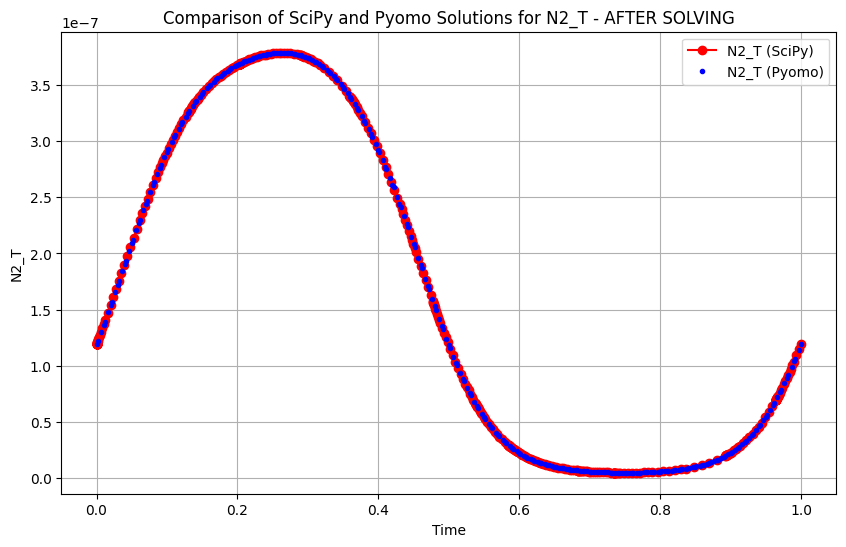

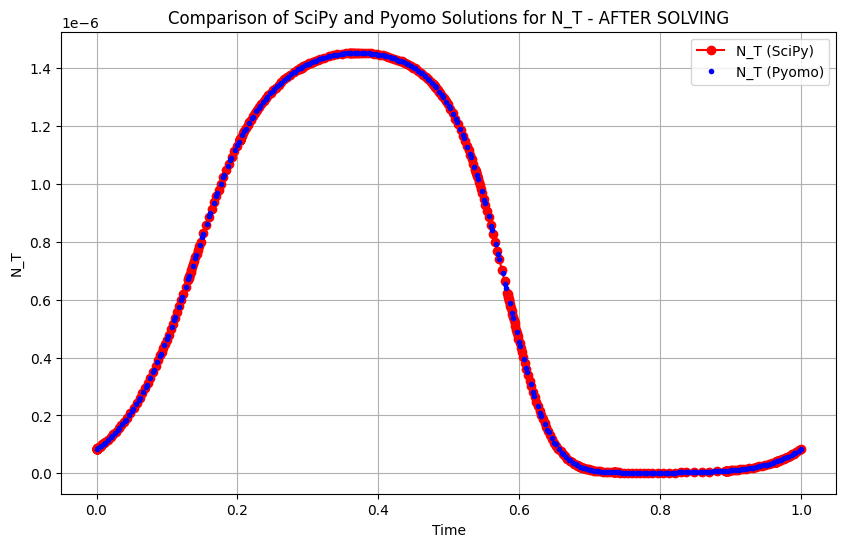

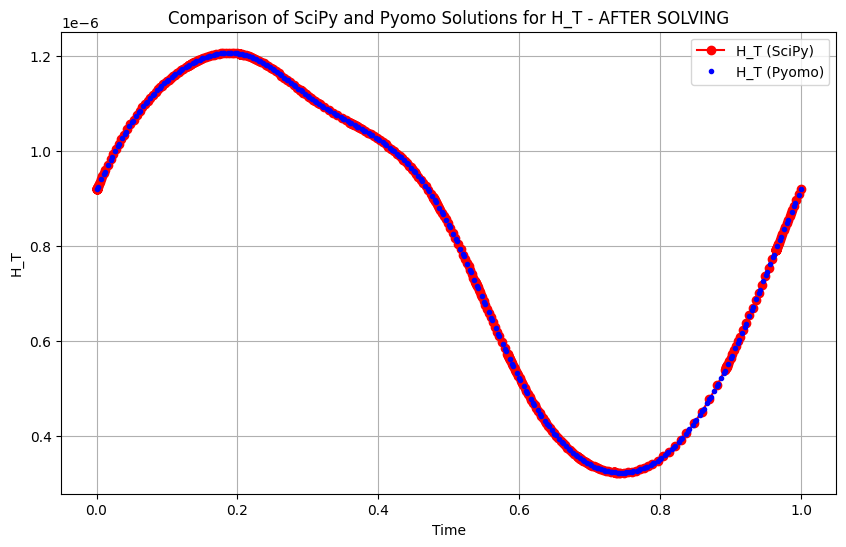

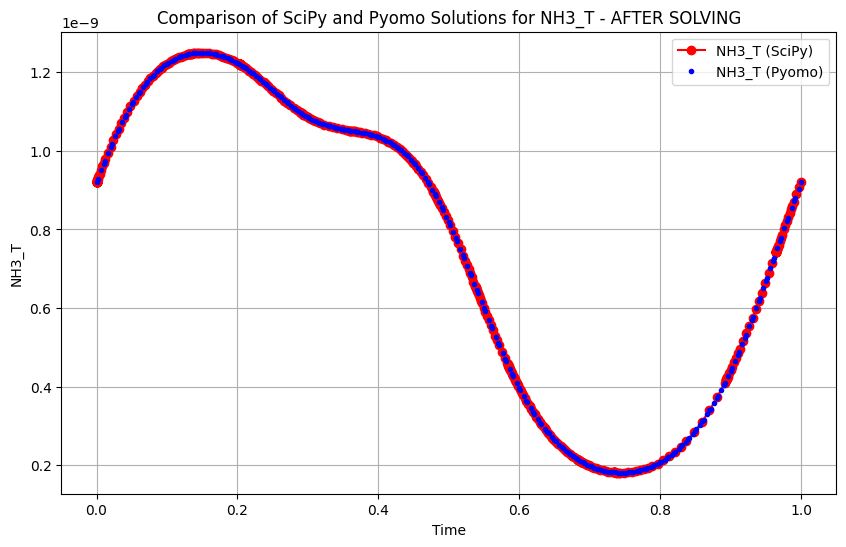

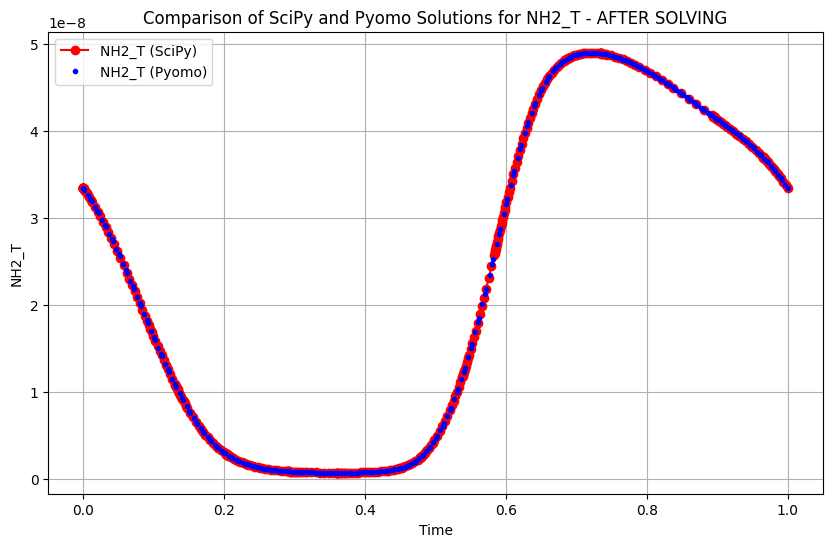

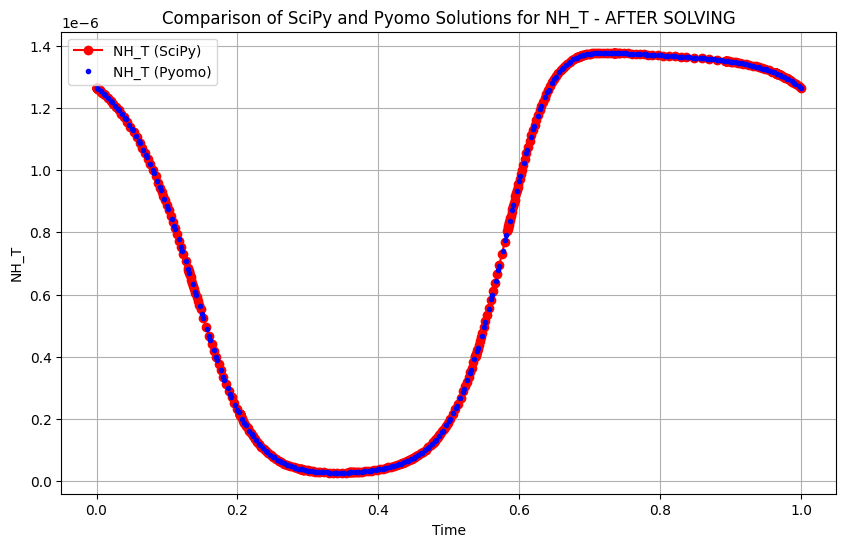

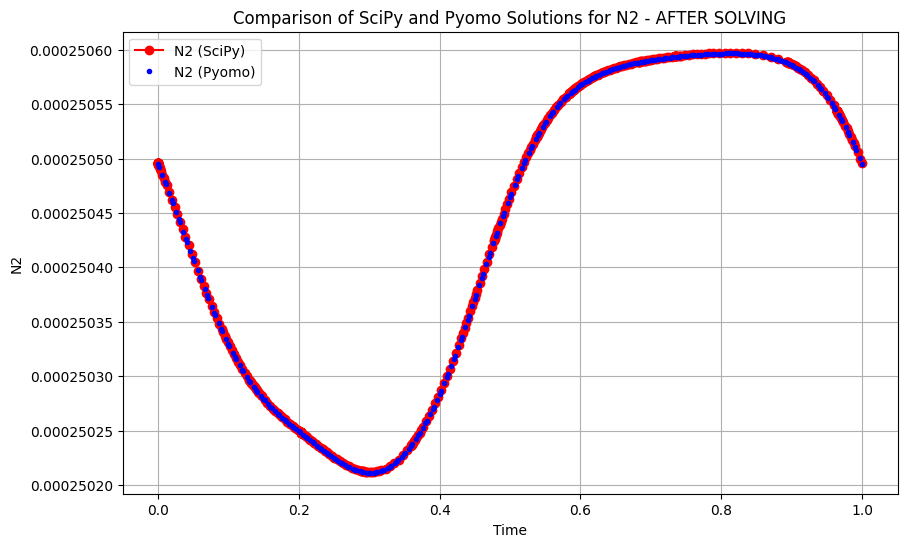

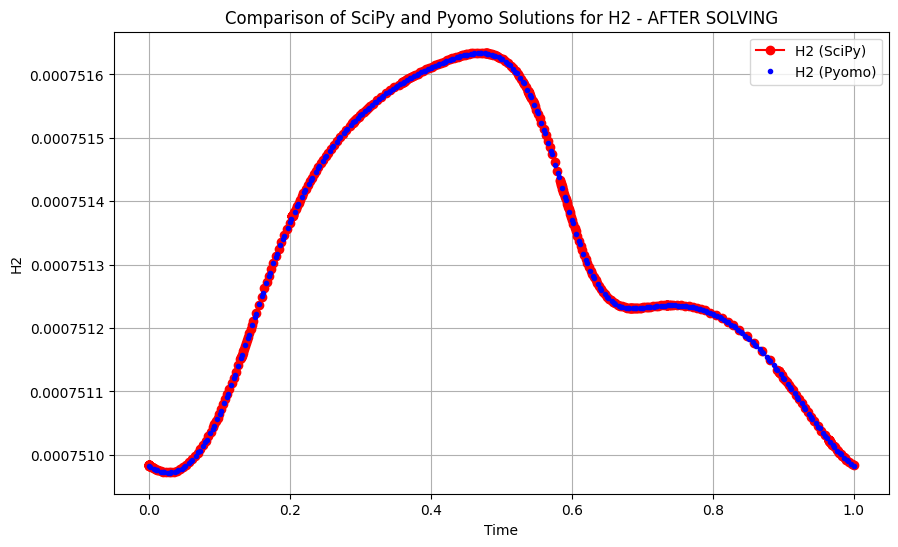

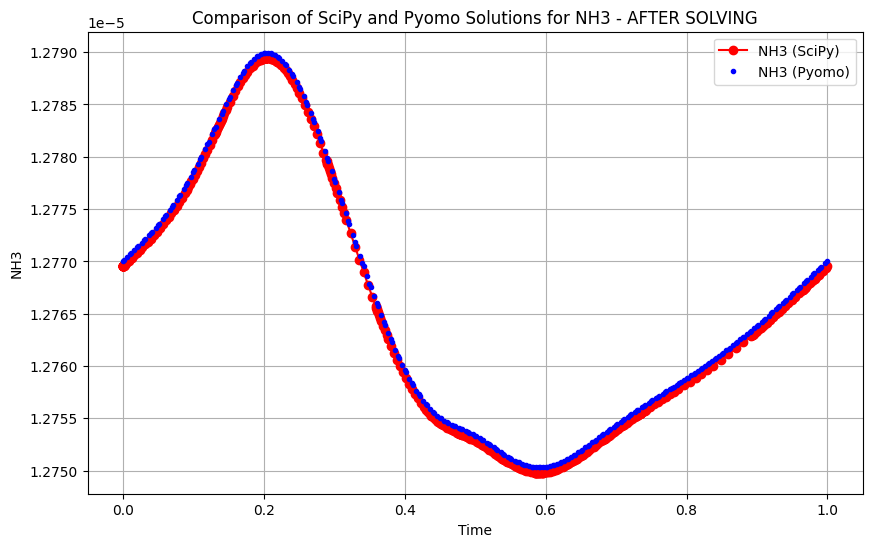

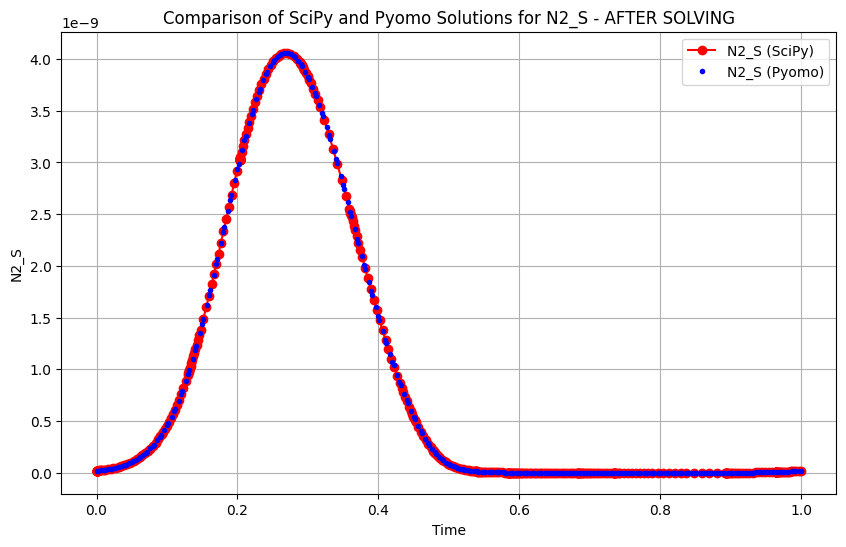

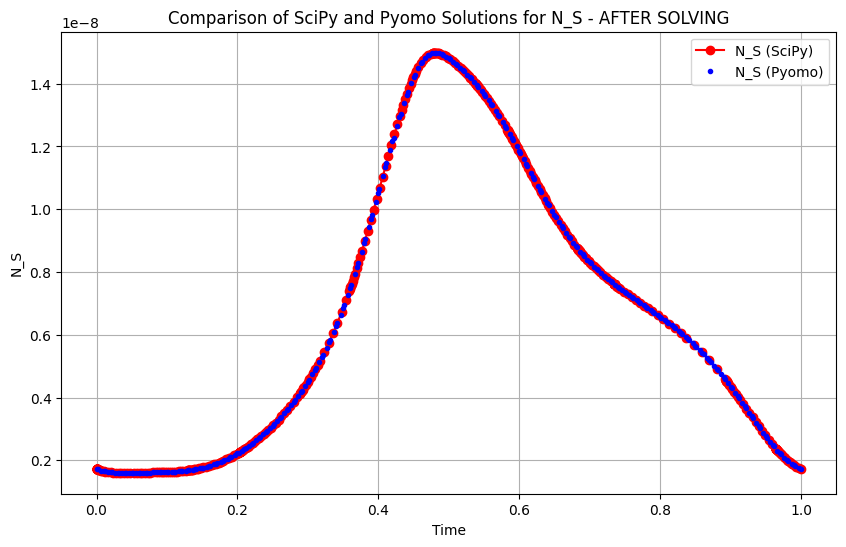

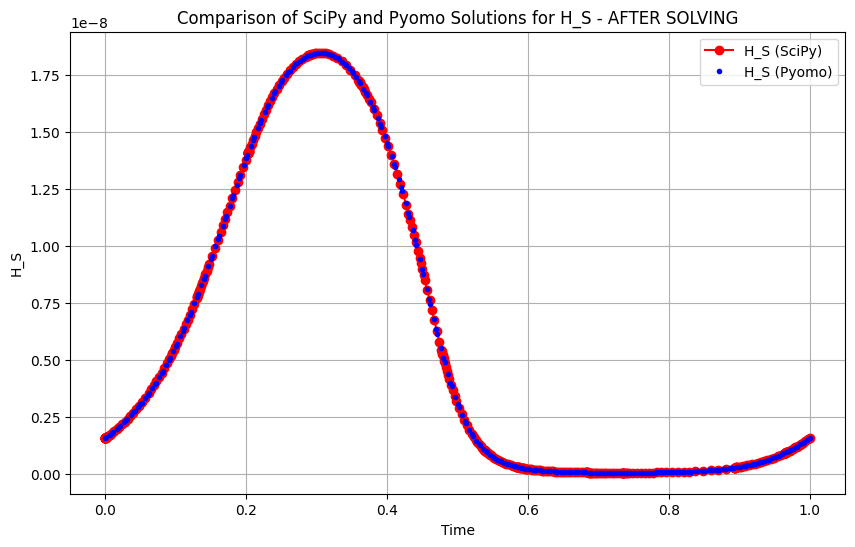

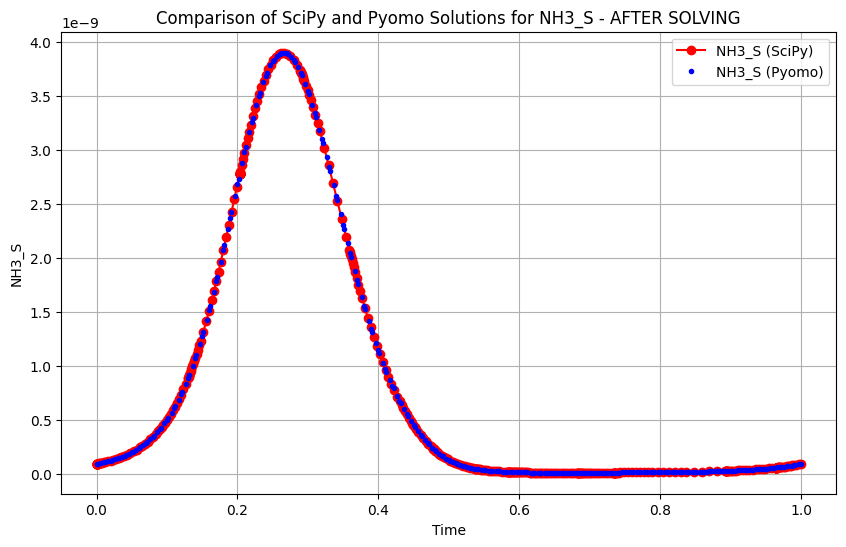

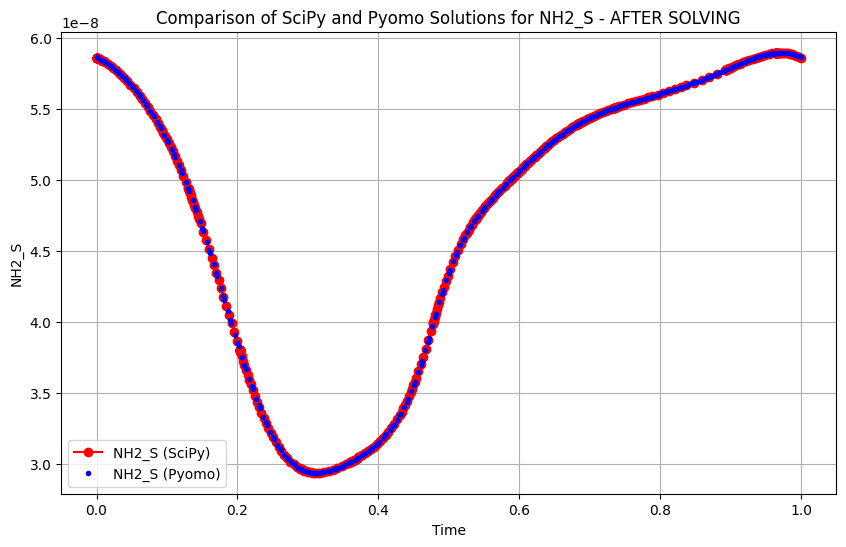

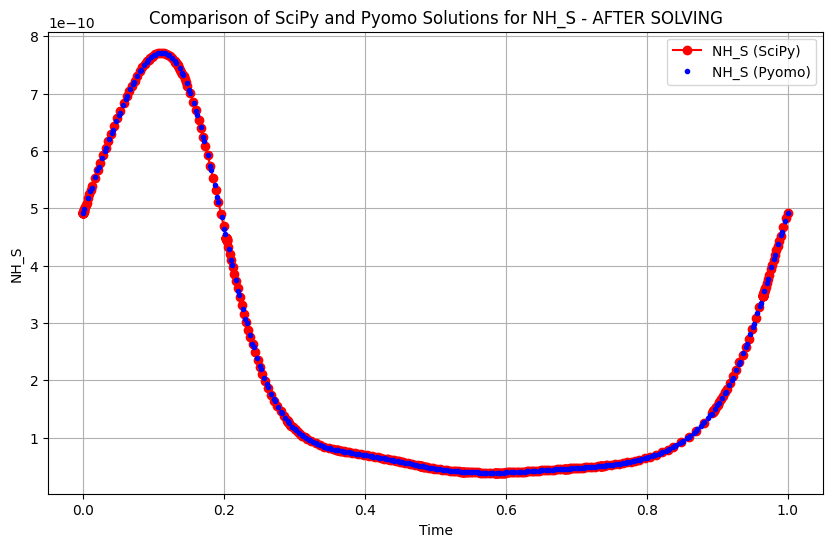

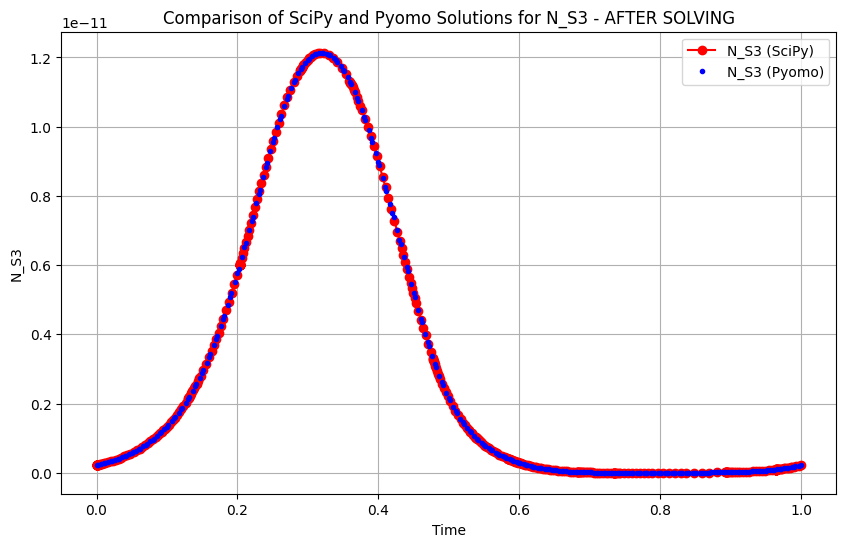

avTOF = 2.03109 Hz, run time = 15.79663 s.


In [ ]:
# Gettings TOF array for plotting
start_time = time.time()

params.freq_osci = 100

TOF, avTOF, N2_T, N_T, H_T, NH3_T, NH2_T, NH_T, N2, H2, NH3, N2_S, N_S, H_S, NH3_S, NH2_S, NH_S, N_S3, pyomo_time = tof_from_decision_vars(params, tee=True)

end_time = time.time()

elapsed_time = end_time - start_time

print(f'avTOF = {avTOF:1.5f} Hz, run time = {elapsed_time:1.5f} s.')

In [ ]:
# Define a handler for the timeout
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

# Set the timeout signal
signal.signal(signal.SIGALRM, timeout_handler)

avTOFs1 = []

frequencies1 = np.linspace(100, 5000, 1000)


for params.freq_osci in frequencies1:
        try:
            # Start the timer for 5 seconds
            signal.alarm(30)

            abyv = params.abyv
            Q_in = params.Q_in
            Q_out = params.Q_out
            V = params.V
            SDTOT  = params.SDTOT

            # we will initialize the next run with the results of the last one
            init_N2_T = N2_T
            init_N_T = N_T
            init_H_T = H_T
            init_NH3_T = NH3_T
            init_NH2_T = NH2_T
            init_NH_T = NH_T

            init_N2 = N2
            init_H2 = H2
            init_NH3 = NH3

            init_N2_S = N2_S
            init_N_S = N_S
            init_H_S = H_S
            init_NH3_S = NH3_S
            init_NH2_S = NH2_S
            init_NH_S = NH_S
            init_N_S3 = N_S3

            m = create_pyomo_model(params)

            # update final time (mutable variable) before running next
            # m.freq_osci = freq_osci


            for i, t in enumerate(m.times):
                m.N2_T[t].set_value(init_N2_T[i])
                m.N_T[t].set_value(init_N_T[i])
                m.H_T[t].set_value(init_H_T[i])
                m.NH3_T[t].set_value(init_NH3_T[i])
                m.NH2_T[t].set_value(init_NH2_T[i])
                m.NH_T[t].set_value(init_NH_T[i])
                m.N2[t].set_value(init_N2[i])
                m.H2[t].set_value(init_H2[i])
                m.NH3[t].set_value(init_NH3[i])
                m.N2_S[t].set_value(init_N2_S[i])
                m.N_S[t].set_value(init_N_S[i])
                m.H_S[t].set_value(init_H_S[i])
                m.NH3_S[t].set_value(init_NH3_S[i])
                m.NH2_S[t].set_value(init_NH2_S[i])
                m.NH_S[t].set_value(init_NH_S[i])
                m.N_S3[t].set_value(init_N_S3[i])

            # Solve the model for these conditions
            solver = SolverFactory('ipopt')
            solver.options['tol'] = 1e-14
            solver.options['acceptable_tol'] = 1e-14
            # solver.options['linear_solver'] = 'ma97'



            results = solver.solve(m, tee=False)
            # assert_optimal_termination(results)

            # update the solution from the last run for posterior initialization of next run
            N2_T = np.asarray([value(m.N2_T[t]) for t in m.times])
            N_T = np.asarray([value(m.N_T[t]) for t in m.times])
            H_T = np.asarray([value(m.H_T[t]) for t in m.times])
            NH3_T = np.asarray([value(m.NH3_T[t]) for t in m.times])
            NH2_T = np.asarray([value(m.NH2_T[t]) for t in m.times])
            NH_T = np.asarray([value(m.NH_T[t]) for t in m.times])
            N2 = np.asarray([value(m.N2[t]) for t in m.times])
            H2 = np.asarray([value(m.H2[t]) for t in m.times])
            NH3 = np.asarray([value(m.NH3[t]) for t in m.times])
            N2_S = np.asarray([value(m.N2_S[t]) for t in m.times])
            N_S = np.asarray([value(m.N_S[t]) for t in m.times])
            H_S = np.asarray([value(m.H_S[t]) for t in m.times])
            NH3_S = np.asarray([value(m.NH3_S[t]) for t in m.times])
            NH2_S = np.asarray([value(m.NH2_S[t]) for t in m.times])
            NH_S = np.asarray([value(m.NH_S[t]) for t in m.times])
            N_S3 = np.asarray([value(m.N_S3[t]) for t in m.times])

            # plotting - only did once to check, takes a long time.
            # pyomo_time = [t for t in m.times]
            # for var_name, init_array in {
            #     'N2_T': init_N2_T, 'N_T': init_N_T, 'H_T': init_H_T, 'NH3_T': init_NH3_T, 'NH2_T': init_NH2_T, 'NH_T': init_NH_T,
            #     'N2': init_N2, 'H2': init_H2, 'NH3': init_NH3,
            #     'N2_S': init_N2_S, 'N_S': init_N_S, 'H_S': init_H_S, 'NH3_S': init_NH3_S, 'NH2_S': init_NH2_S, 'NH_S': init_NH_S, 'N_S3': init_N_S3
            # }.items():
            #     pyomo_var_unscaled = np.asarray([value(getattr(m, var_name)[t]) for t in m.times])

            #     plt.figure(figsize=(6, 4))
            #     plt.plot(pyomo_time, pyomo_var_unscaled, 'b.', label=f'{var_name} (Solution)')
            #     plt.plot(pyomo_time, init_array, 'g--', label=f'{var_name} (Initialization - From Array)')
            #     plt.xlabel('Time', fontsize=16)
            #     plt.ylabel(var_name, fontsize=16)
            #     plt.title(f'{var_name} - Frequency: {freq_osci} 1/s', fontsize=18)
            #     plt.legend(fontsize=16)
            #     plt.grid(True)
            #     plt.show()

            # Calculate avTOF
            ic = initial_calculations(params)
            NH3_MF = NH3 / (N2 + H2 + NH3)
            NH2_Conv = 1 - ((1 - NH3_MF) / (1 + NH3_MF))
            TOF = ic.c_N2 * Q_in * NH2_Conv / SDTOT / abyv
            avTOF = np.trapz(TOF, m.times)
            avTOFs1.append(avTOF)

            print(f'For frequency = {params.freq_osci:.2f} 1/s, avTOF = {avTOF:.6f} 1/s')


            # Stop the timer after successful completion
            signal.alarm(0)

        except TimeoutException:
            # Skip this step if it takes too long
            print(f'Skipping frequency = {params.freq_osci:.5f} due to timeout')
            avTOFs1.append(None)

# Reset the alarm signal after the loop
signal.alarm(0)

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results were given in {elapsed_time/60:1.2f} min.')


<ipython-input-91-c8b2a82e3799>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kf[1] = 1 * A[0] * ((T / T_ref) ** beta[1]) / abyv * np.exp(-Ea[1] / (R_e * T))  # N2(T)  +  *(T) <--> 2N(T)
<ipython-input-91-c8b2a82e3799>:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kf[3] = 1 * A[1] * ((T / T_ref) ** beta[3]) / abyv * np.exp(-Ea[3] / (R_e * T))  # NH3(T) +  *(T) <--> NH2(T) + H(T)
<ipython-input-91-c8b2a82e3799>:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

Discretizing...
Discretized in 301 points


<ipython-input-99-72ab8aff951d>:124: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  avTOF = np.trapz(TOF, m.times)


For frequency = 100.00 1/s, avTOF = 2.031059 1/s
Discretizing...
Discretized in 301 points
Skipping frequency = 104.90490 due to timeout
Discretizing...
Discretized in 301 points
Skipping frequency = 109.80981 due to timeout
Discretizing...
Discretized in 301 points
For frequency = 114.71 1/s, avTOF = 2.044996 1/s
Discretizing...
Discretized in 301 points
Skipping frequency = 119.61962 due to timeout
Discretizing...
Discretized in 301 points
For frequency = 124.52 1/s, avTOF = 2.051005 1/s
Discretizing...
Discretized in 301 points
Skipping frequency = 129.42943 due to timeout
Discretizing...
Discretized in 301 points
Skipping frequency = 134.33433 due to timeout
Discretizing...
Discretized in 301 points
Skipping frequency = 139.23924 due to timeout
Discretizing...
Discretized in 301 points
Skipping frequency = 144.14414 due to timeout
Discretizing...
Discretized in 301 points
For frequency = 149.05 1/s, avTOF = 2.059970 1/s
Discretizing...
Discretized in 301 points
For frequency = 153.

<ipython-input-91-c8b2a82e3799>:78: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kf[1] = 1 * A[0] * ((T / T_ref) ** beta[1]) / abyv * np.exp(-Ea[1] / (R_e * T))  # N2(T)  +  *(T) <--> 2N(T)
<ipython-input-91-c8b2a82e3799>:87: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kf[3] = 1 * A[1] * ((T / T_ref) ** beta[3]) / abyv * np.exp(-Ea[3] / (R_e * T))  # NH3(T) +  *(T) <--> NH2(T) + H(T)
<ipython-input-91-c8b2a82e3799>:90: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)

Discretizing...
Discretized in 301 points
Ipopt 3.13.2: tol=0.0001


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for la

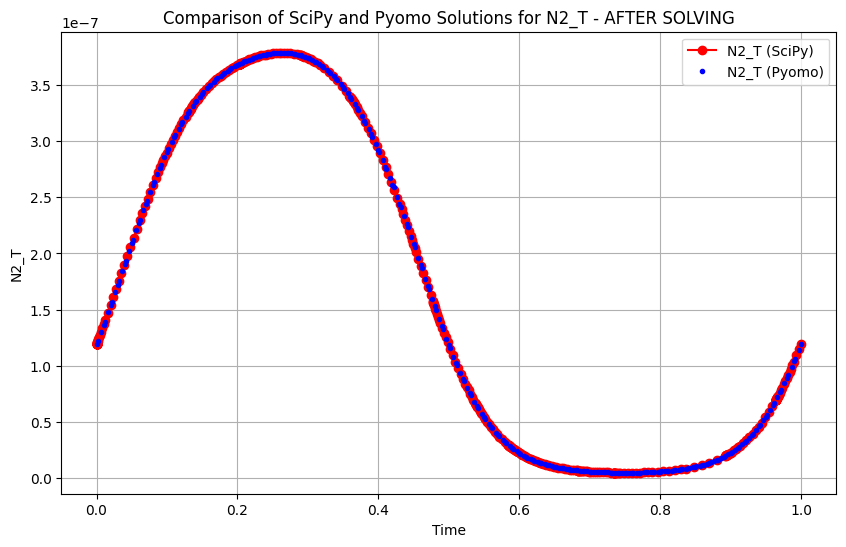

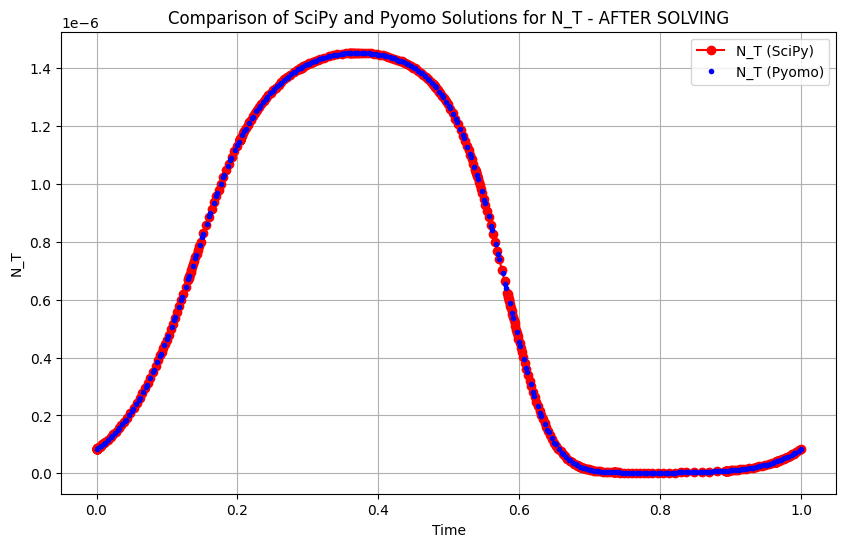

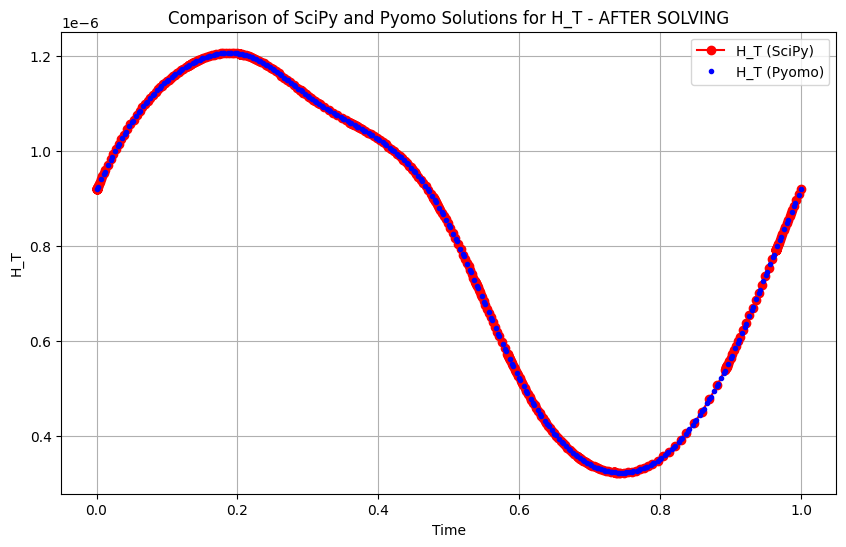

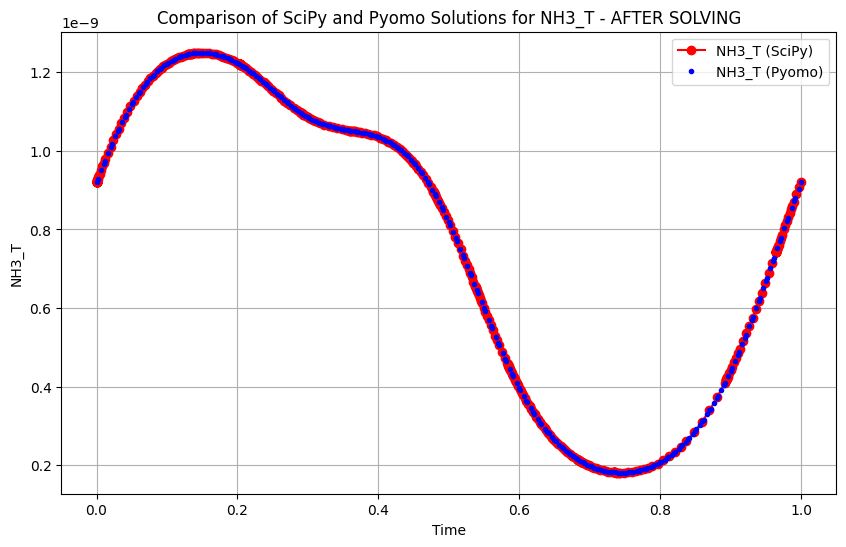

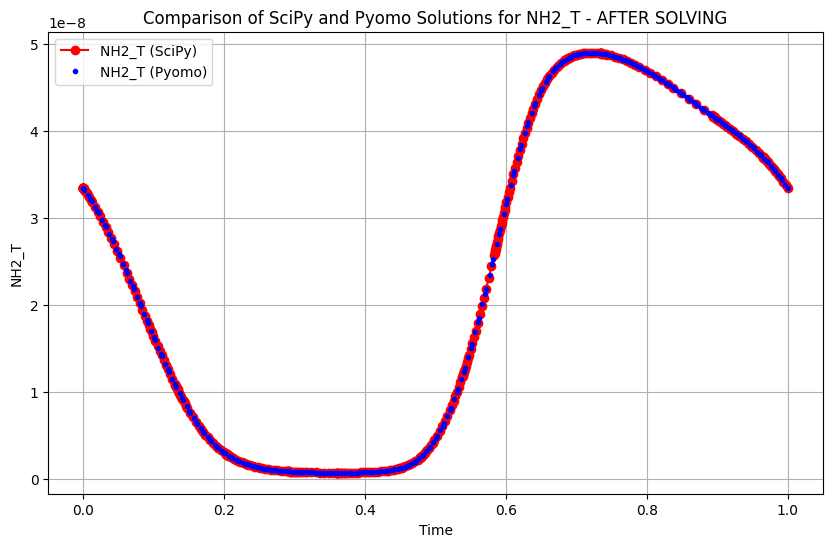

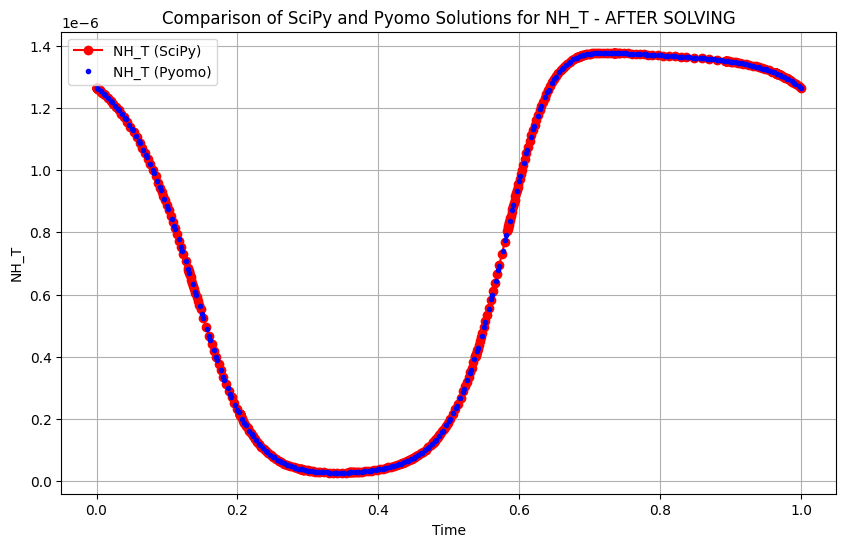

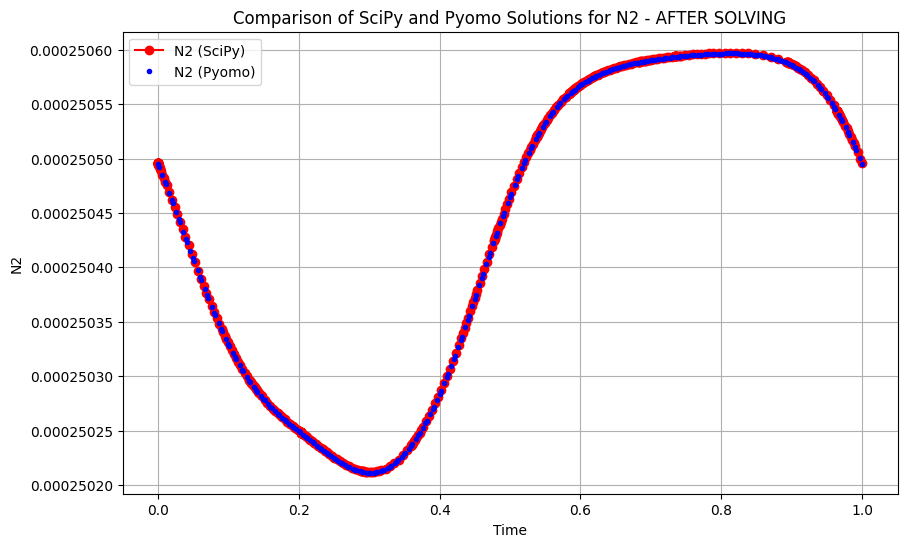

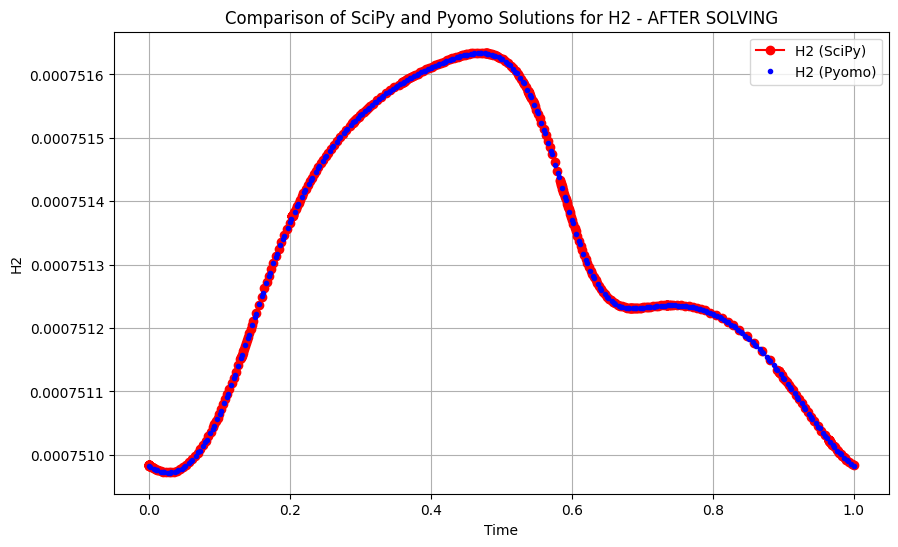

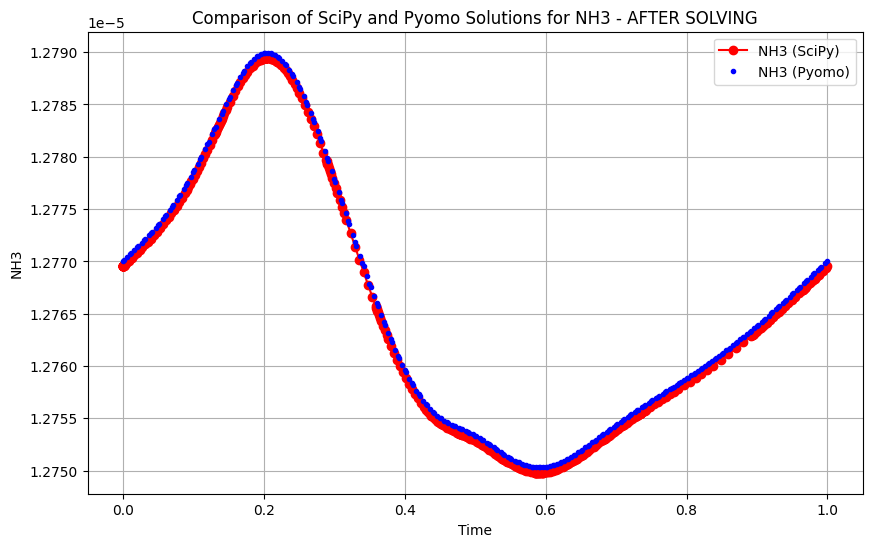

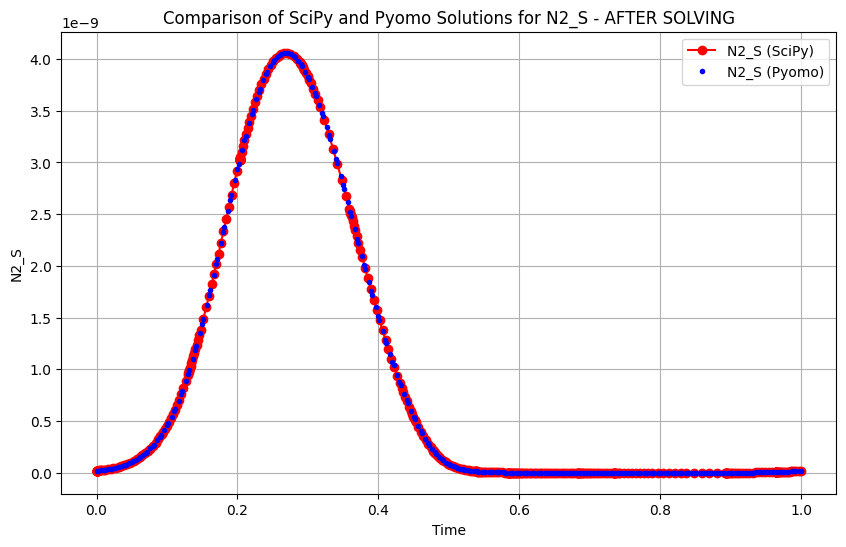

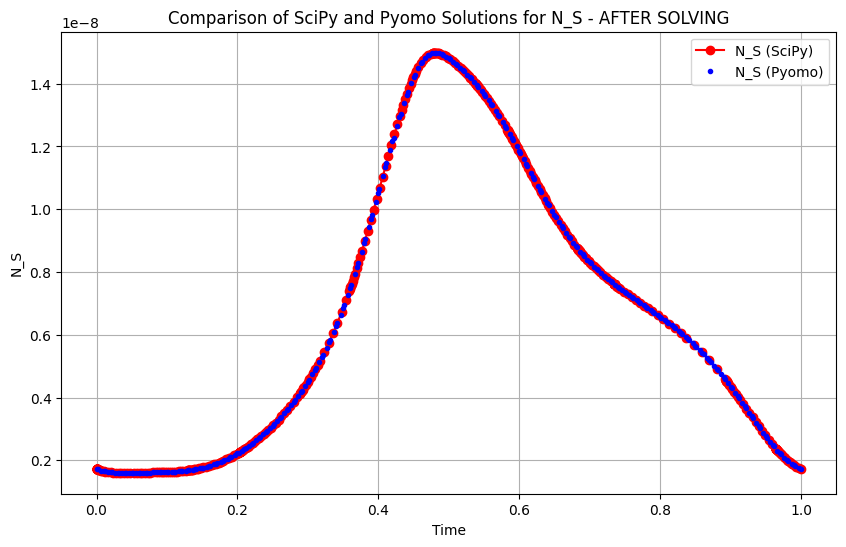

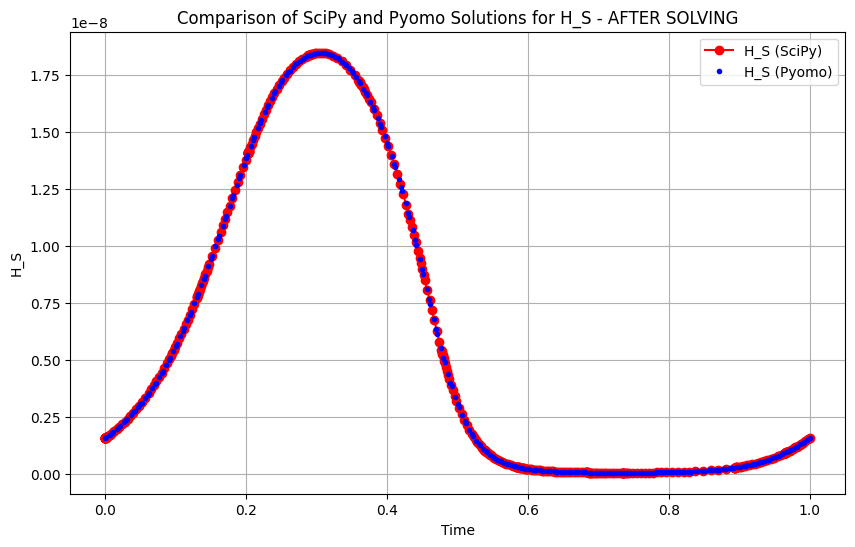

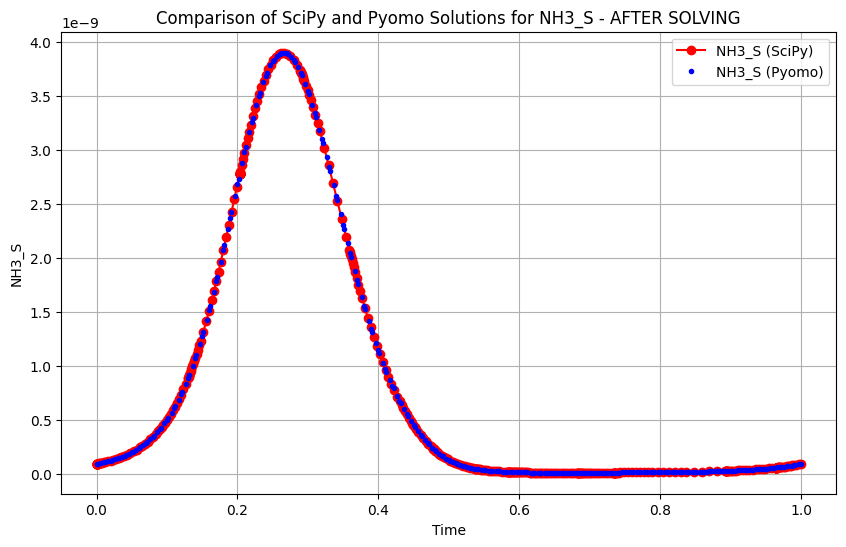

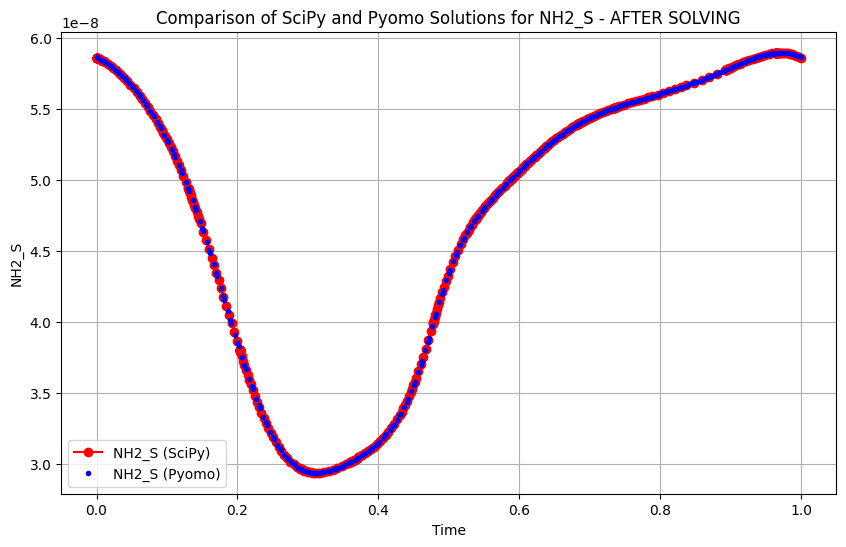

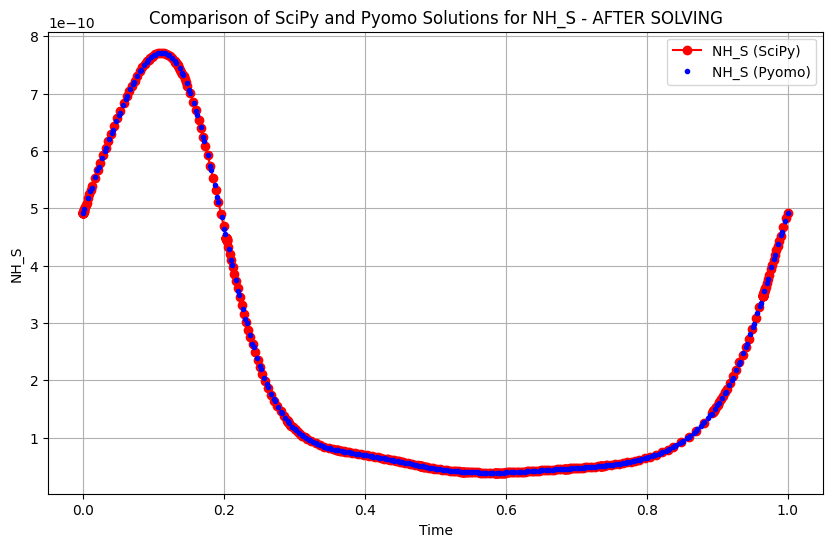

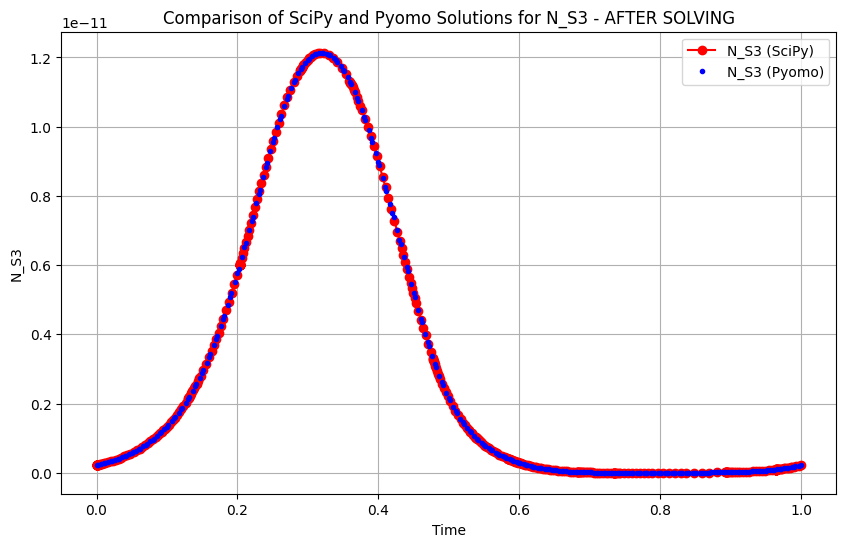

avTOF = 2.03109 Hz, run time = 13.13746 s.


In [ ]:
# Gettings TOF array for plotting
start_time = time.time()

params.freq_osci = 100

TOF, avTOF, N2_T, N_T, H_T, NH3_T, NH2_T, NH_T, N2, H2, NH3, N2_S, N_S, H_S, NH3_S, NH2_S, NH_S, N_S3, pyomo_time = tof_from_decision_vars(params, tee=True)

end_time = time.time()

elapsed_time = end_time - start_time

print(f'avTOF = {avTOF:1.5f} Hz, run time = {elapsed_time:1.5f} s.')

In [ ]:
# Define a handler for the timeout
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    raise TimeoutException

# Set the timeout signal
signal.signal(signal.SIGALRM, timeout_handler)

avTOFs2 = []

frequencies2 = np.linspace(100, 20, 50)


for params.freq_osci in frequencies2:
        try:
            signal.alarm(60)

            abyv = params.abyv
            Q_in = params.Q_in
            Q_out = params.Q_out
            V = params.V
            SDTOT  = params.SDTOT

            # we will initialize the next run with the results of the last one

            m = create_pyomo_model(params)

            # update final time (mutable variable) before running next
            # m.freq_osci = freq_osci


            for i, t in enumerate(m.times):
                m.N2_T[t].set_value(N2_T[i])
                m.N_T[t].set_value(N_T[i])
                m.H_T[t].set_value(H_T[i])
                m.NH3_T[t].set_value(NH3_T[i])
                m.NH2_T[t].set_value(NH2_T[i])
                m.NH_T[t].set_value(NH_T[i])
                m.N2[t].set_value(N2[i])
                m.H2[t].set_value(H2[i])
                m.NH3[t].set_value(NH3[i])
                m.N2_S[t].set_value(N2_S[i])
                m.N_S[t].set_value(N_S[i])
                m.H_S[t].set_value(H_S[i])
                m.NH3_S[t].set_value(NH3_S[i])
                m.NH2_S[t].set_value(NH2_S[i])
                m.NH_S[t].set_value(NH_S[i])
                m.N_S3[t].set_value(N_S3[i])


            solver = SolverFactory('ipopt')
            solver.options['tol'] = 1e-14
            solver.options['acceptable_tol'] = 1e-14


            # Solve the model for these conditions
            results = solver.solve(m, tee=True)

            # Update the solution from the last run for posterior initialization of the next run
            N2_T = np.asarray([value(m.N2_T[t]) for t in m.times])
            N_T = np.asarray([value(m.N_T[t]) for t in m.times])
            H_T = np.asarray([value(m.H_T[t]) for t in m.times])
            NH3_T = np.asarray([value(m.NH3_T[t]) for t in m.times])
            NH2_T = np.asarray([value(m.NH2_T[t]) for t in m.times])
            NH_T = np.asarray([value(m.NH_T[t]) for t in m.times])
            N2 = np.asarray([value(m.N2[t]) for t in m.times])
            H2 = np.asarray([value(m.H2[t]) for t in m.times])
            NH3 = np.asarray([value(m.NH3[t]) for t in m.times])
            N2_S = np.asarray([value(m.N2_S[t]) for t in m.times])
            N_S = np.asarray([value(m.N_S[t]) for t in m.times])
            H_S = np.asarray([value(m.H_S[t]) for t in m.times])
            NH3_S = np.asarray([value(m.NH3_S[t]) for t in m.times])
            NH2_S = np.asarray([value(m.NH2_S[t]) for t in m.times])
            NH_S = np.asarray([value(m.NH_S[t]) for t in m.times])
            N_S3 = np.asarray([value(m.N_S3[t]) for t in m.times])


            # plotting - only did once to check, takes a long time.
            # pyomo_time = [t for t in m.times]
            # for var_name, init_array in {
            #     'N2_T': init_N2_T, 'N_T': init_N_T, 'H_T': init_H_T, 'NH3_T': init_NH3_T, 'NH2_T': init_NH2_T, 'NH_T': init_NH_T,
            #     'N2': init_N2, 'H2': init_H2, 'NH3': init_NH3,
            #     'N2_S': init_N2_S, 'N_S': init_N_S, 'H_S': init_H_S, 'NH3_S': init_NH3_S, 'NH2_S': init_NH2_S, 'NH_S': init_NH_S, 'N_S3': init_N_S3
            # }.items():
            #     pyomo_var_unscaled = np.asarray([value(getattr(m, var_name)[t]) for t in m.times])

            #     plt.figure(figsize=(6, 4))
            #     plt.plot(pyomo_time, pyomo_var_unscaled, 'b.', label=f'{var_name} (Solution)')
            #     plt.plot(pyomo_time, init_array, 'g--', label=f'{var_name} (Initialization - From Array)')
            #     plt.xlabel('Time', fontsize=16)
            #     plt.ylabel(var_name, fontsize=16)
            #     plt.title(f'{var_name} - Frequency: {freq_osci} 1/s', fontsize=18)
            #     plt.legend(fontsize=16)
            #     plt.grid(True)
            #     plt.show()

            # Calculate avTOF
            ic = initial_calculations(params)
            NH3_MF = NH3 / (N2 + H2 + NH3)
            NH2_Conv = 1 - ((1 - NH3_MF) / (1 + NH3_MF))
            TOF = ic.c_N2 * Q_in * NH2_Conv / SDTOT / abyv
            avTOF = np.trapz(TOF, m.times)
            avTOFs2.append(avTOF)

            print(f'For frequency = {params.freq_osci:.2f} 1/s, avTOF = {avTOF:.6f} 1/s')


            # Stop the timer after successful completion
            signal.alarm(0)

        except TimeoutException:
            # Skip this step if it takes too long
            print(f'Skipping frequency = {params.freq_osci:.5f} due to timeout')
            avTOFs2.append(None)

# Reset the alarm signal after the loop
signal.alarm(0)

end_time = time.time()

elapsed_time = end_time - start_time

print(f'Results were given in {elapsed_time/60:1.2f} min.')


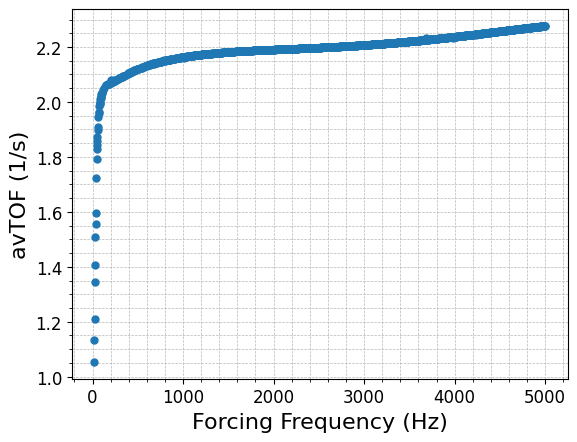

In [ ]:
# Concatenate the arrays/lists
frequencies =  frequencies2.tolist()  + frequencies1.tolist()
avTOFs = avTOFs2 +avTOFs1

plt.figure()
plt.plot(frequencies, avTOFs, '.', markersize=10)
plt.xlabel('Forcing Frequency (Hz)', fontsize=16)
plt.ylabel('avTOF (1/s)', fontsize=16)
plt.grid(
    which='both',
    linestyle='--',
    linewidth=0.5,
    alpha=0.9
)
plt.minorticks_on()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.savefig('freq_plot.png', dpi=300, bbox_inches='tight')

plt.show()
